# Project: predicting orders for Glovo

Imagine you just joined Glovo. Glovo follows a slot-based system for the couriers to fullfil the orders that come in. For simplification, you can imagine those slots are non-overlapping hours, so that every every city has 24 slots every day, one for each hour. Glovo needs to know the optimal number of couriers that are needed on every hour slot of every city. Too many couriers, and there will be many idle couriers not earning money. Too few couriers, and orders will have to wait to be processed, leading to higher delivery times.

At the moment, Operations decides manually how many couriers are needed, based on past demand. As the number of cities grows, this becomes unsustainable. They want to automate the process by which they decide how many courier-slots should be opened every hour. For simplification, we can assume that every Sunday at midnight, we need to know how many couriers we need for every hour of the week that is starting. That means that if today is Sunday, May 8th 23:59, they want us to know how many orders will be placed every hour of the week that goes from May 9th 00:00 to May 15th 23:00, both included. Every Sunday, you can use all data from that week to forecast the next one.

This problem has many steps, but we will keep this project to the order forecast for one city: we want to know, for one city and every Sunday, how many orders we're going to receive on every hour of the upcoming week.

## EDA

Load the file data_BCN.csv

Explore the data, visualise it. Look for trends, cycles and seasonalities. Also, can you find any outliers? days or hours that break those patterns?


## Glovo features

- Past Orders
    - Orders in the previous year
- Day effect
    - What was the shrink effect (not relevant for just one year of data)
- Football match importance
    - If there is no football match in the orresponding time frame, 0. Teams in the first four places, 1. Second four places, 0.5. Third four places, 0.25. Cumulative (top 4 vs third 4 = 1.25)
- Store impact
    - Promotion data. Proportion of orders that came 1 week before the promotion
- Weather
    - Temperature
    - Wind speed
    - Precipitation intensity
    - Comes from DarkSky API

ARIMAX 3,2,5 and ARIMAX 3,2,6

### Aggregate orders trends

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
import numpy as np
import datetime as dt
from pyowm import OWM
import seaborn as sns
import statsmodels as sm
import plotly.express as px

WEATHER_API_KEY = 'R7EKMHVN3H2BJR8HML7P5Q2LJ'

data = pd.read_csv('./data_BCN.csv')
data['time'] = pd.to_datetime(data['time'], format='%Y-%m-%d %H:%M:%S')
data.index = data['time']
px.line(data, x='time', y='orders')


In [2]:

daily = data.resample('D', on='time').sum(numeric_only=True).copy()

px.line(daily, x=daily.index, y='orders', title='Daily agg sales')


We can see 5 major spikes at the daily level:
- March 26 (Kings League final game hosted in Barcelona)
- July 23 (Opening ceremony of the Tokyo Olympics)
- September 24 (the Festival of Merce)
- November 7 (unclear)
- December 5 (unclear)

In [3]:

weekly = data.resample('W', on='time').sum(numeric_only=True).copy()

px.line(weekly, x=weekly.index, y='orders', title='Weekly agg sales')


It looks like there was a stark drop of orders somewhere between August 1 and September 12. Is it possible that we have any missing values?

In [4]:

# Resample data to monthly frequency
monthly = data.resample('M').sum(numeric_only=True).copy()

# Convert index to string format
monthly['month'] = monthly.index.strftime('%Y-%m')

# Create a line plot with categorical x-axis
fig = px.line(monthly, x='month', y='orders', title='Monthly Sales Aggregation')

# Set x-axis tickmode to 'linear' and tickangle to 45 degrees
fig.update_layout(xaxis={'type': 'category', 'tickmode': 'linear', 'tickangle': 0})

# Display the plot
fig.show()


This verifies the issue of lower than expected orders in August. Is this seasonality, or missing data?

Other than this, we're also seeing a trend of increasing orders. This is expected for a start-up. We need to make sure that we choose a model that can integrate this growth factor into the prediction. 

Let's also investigate orders by day of the week. Is there weekly seasonality?

In [5]:
import calendar

# Define the order of weekdays
weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Resample data to daily frequency
weekly = data.resample('D').mean(numeric_only=True).copy()

# Get the day of the week as abbreviated names
weekly['day_of_week'] = weekly.index.strftime('%A')
weekly['day_of_week_abbr'] = weekly.index.map(lambda x: calendar.day_abbr[x.weekday()])

# Set the categorical order of the day of the week
weekly['day_of_week_abbr'] = pd.Categorical(weekly['day_of_week_abbr'], categories=weekday_order, ordered=True)

# Group and calculate the mean by day of the week
weekly_mean = weekly.groupby('day_of_week_abbr')['orders'].mean()

# Plot the line chart
px.line(x=weekly_mean.index, y=weekly_mean.values, title='Weekly Mean Sales by Day of the Week', labels={'x': 'Day of the Week'})


Yes, it seems that Monday - Thursday have significantly lower orders than Friday - Sunday. Is it all hours on Friday/Saturday/Sunday that have higher orders than the rest of the week?

In [8]:
# Add 'hour' and 'day' columns to the DataFrame
data['hour'] = data.index.hour
data['day'] = data.index.day_name()

# Exclude hours 0-5 and 23
filtered_data = data[~data['hour'].isin(range(0, 6)) & (data['hour'] != 23)]

# Calculate the mean number of orders for each hour and day of the week
heatmap_data = filtered_data.groupby(['hour', 'day'])['orders'].mean().unstack()

# Reorder the columns so they start from Monday
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data[ordered_days]


In [10]:
import plotly.express as px

fig = px.imshow(heatmap_data, labels=dict(x="Day of the Week", y="Hour of the Day", color="Average Orders"),
                 x=ordered_days)
fig.update_xaxes(side="top")
fig.show()


Takeaways from the hourly data:
- Friday/Saturday consistently have the highest orders at 2100
- Trends for the whole week are pretty consistent between 0600-1200, and 1600-1800

Now, let's go ahead and define the spikes as time slots that have mean hourly values that are >=1 standard deviation above the mean. That is, identifying about the top 16% of values as seasonal trends. 

In [11]:
# Flatten the data and calculate the mean and standard deviation
flat_data = heatmap_data.values.flatten()
mean = flat_data.mean()
std_dev = flat_data.std()

# Set a threshold for what you consider a spike/dip (e.g., 2 standard deviations from the mean)
threshold = mean + std_dev

# Now you can use this threshold to identify hours of the week that have a seasonal spike
spikes = heatmap_data > threshold


In [12]:
spikes

day,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
hour,,,,,,,
6,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False
10,False,False,False,False,False,False,False
11,False,False,False,False,False,False,False
12,False,False,False,False,False,False,False
13,False,False,False,True,True,False,True
14,False,False,False,False,False,False,True


Intuitively this makes sense. We see spikes on Sunday lunch time, and 2100 of all days but Monday. Let's save this as a dataframe to use later. 

In [13]:
# Reset the index to melt the DataFrame properly
spikes_reset = spikes.reset_index()

# Melt the DataFrame
spikes = pd.melt(spikes_reset, id_vars='hour', value_vars=spikes.columns[1:], var_name='day', value_name='spike')

# Convert the spike column to integers (True becomes 1, False becomes 0)
spikes['spike'] = spikes['spike'].astype(int)


In [14]:
spikes

,hour,day,spike
0,6,Tuesday,0
1,7,Tuesday,0
2,8,Tuesday,0
3,9,Tuesday,0
4,10,Tuesday,0
...,...,...,...
97,18,Sunday,0
98,19,Sunday,0
99,20,Sunday,1
100,21,Sunday,1


### Weather

I'm curious if there is a correlation between weather and orders. The CSV attached is Barcelona temperature and precipitation data from the [US government National Centers for Environmental Information](https://www.ncei.noaa.gov/). 

In [15]:
df_weather = pd.read_csv('./bcn_weather.csv')

In [16]:
# Group the data by 'DATE' and calculate the desired aggregations
df_weather_agg = df_weather.groupby('DATE').agg({
    'PRCP': ['sum', 'mean'],
    'TMAX': 'mean',
    'TMIN': 'mean',
    'PRCP_ATTRIBUTES': lambda x: ', '.join(x.dropna().astype(str)) if x.dtype != np.float64 else ''
})

# Flatten the column names
df_weather_agg.columns = ['prcp_sum', 'prcp_avg', 'tmax_avg', 'tmin_avg', 'prcp_attributes']

# Reset the index to make 'DATE' a column
df_weather_agg = df_weather_agg.reset_index()

# Select the desired columns
df_weather_agg = df_weather_agg[['DATE', 'prcp_sum', 'prcp_avg', 'tmax_avg', 'tmin_avg', ]]

df_weather_agg['DATE'] = pd.to_datetime(df_weather_agg['DATE'])


In [17]:
# Convert the date columns to datetime type
daily['date'] = pd.to_datetime(daily.index.date)
df_weather_agg['DATE'] = pd.to_datetime(df_weather_agg['DATE'])

# Merge the 'data' DataFrame with 'df_weather_agg' based on the date
df_orders_weather = pd.merge(daily, df_weather_agg, left_on='date', right_on='DATE', how='left')

# Set the datetime index of the merged DataFrame
df_orders_weather.set_index('date', inplace=True)

# Drop the unnecessary columns
df_orders_weather.drop(columns=['DATE'], inplace=True)

In [18]:
df_orders_weather.head()

,orders,prcp_sum,prcp_avg,tmax_avg,tmin_avg
date,,,,,
2021-02-01,1562.0,7.7,0.452941,19.029412,10.052941
2021-02-02,1348.0,0.0,0.000000,19.411765,7.864706
2021-02-03,1371.0,0.0,0.000000,19.994118,8.147059
2021-02-04,1417.0,0.0,0.000000,17.264706,7.317647
2021-02-05,1548.0,0.0,0.000000,17.152941,9.300000


Now let's create a correlation matrix. 

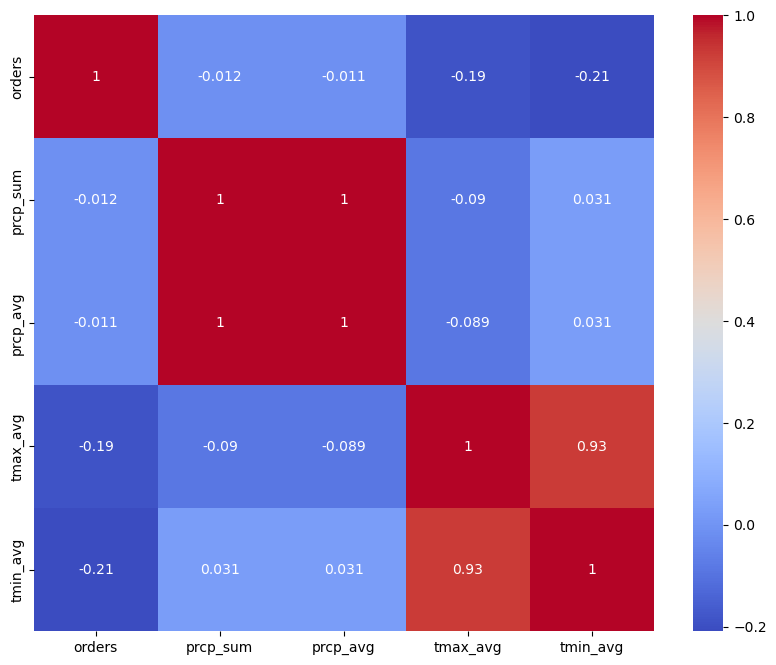

In [19]:
correlation_matrix = df_orders_weather[['orders', 'prcp_sum', 'prcp_avg', 'tmax_avg', 'tmin_avg']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

There's a slight correlation between temperature and orders. Surprisingly there's less of a correlation between precipitation and orders, but this might also be due to the aggregate nature of the data I have access to. If we reduce to hourly granularity it might show more of a correlation. For now I think we can use `tmin_avg` as a feature. 

### Missing values

So far the only concerning piece of this dataset is the sharp drop in orders in August. My impression is that August is the time when most people take off work and go traveling, so with fewer locals in Barcelona there are fewer orders. Intuitively this makes sense but let's investigate to ensure that there are no missing or incorrect values in the dataset. 

In [20]:
print('NaN values in Orders: ', data['orders'].isna().sum())

NaN values in Orders:  0


No NaN values in the dataset. Let's see how the distribution of sales looks by hour for the months around the stark drop in sales, to see if there are any potentially missing or incorrect values in the dataset.

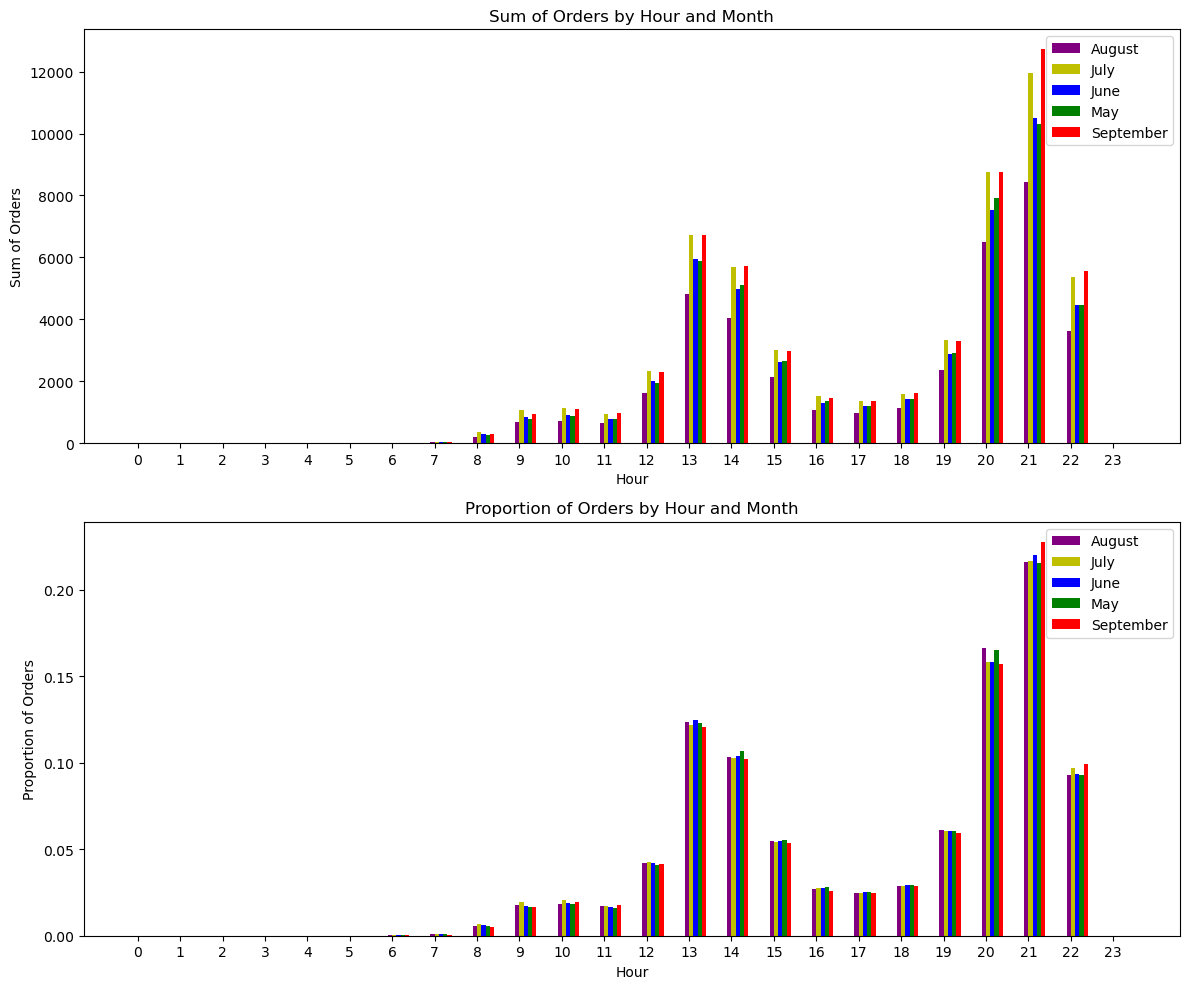

In [21]:
data['time'] = pd.to_datetime(data['time'])
start_date = pd.to_datetime('2021-05-01')
end_date = pd.to_datetime('2021-09-30')
data_period = data[(data['time'] >= start_date) & (data['time'] <= end_date)].copy()
data_period['month'] = data_period['time'].dt.month_name()
all_hours = pd.DataFrame(index=pd.MultiIndex.from_product([range(24), data_period['month'].unique()], names=['time', 'month']))
month_orders = data_period.groupby(['month', data_period['time'].dt.hour])['orders'].sum()
month_orders_full = all_hours.join(month_orders).fillna(0)
month_orders_pivot = month_orders_full.reset_index().pivot(index='time', columns='month', values='orders')
month_orders_proportion = month_orders_pivot.divide(month_orders_pivot.sum(axis=0), axis=1)

bar_width = 0.1
x = np.arange(24)
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
colors = ['purple','y','b', 'g', 'r']

for i, col in enumerate(month_orders_pivot.columns):
    axs[0].bar(x - bar_width/2 + i*bar_width, month_orders_pivot[col], width=bar_width, label=f'{col}', color=colors[i])

axs[0].set_xlabel('Hour')
axs[0].set_ylabel('Sum of Orders')
axs[0].set_title('Sum of Orders by Hour and Month')
axs[0].set_xticks(x)
axs[0].legend()

for i, col in enumerate(month_orders_proportion.columns):
    axs[1].bar(x - bar_width/2 + i*bar_width, month_orders_proportion[col], width=bar_width, label=f'{col}', color=colors[i])

axs[1].set_xlabel('Hour')
axs[1].set_ylabel('Proportion of Orders')
axs[1].set_title('Proportion of Orders by Hour and Month')
axs[1].set_xticks(x)
axs[1].legend()

plt.tight_layout()
plt.show()


Takeaways:
- No orders happen between hours 0-5, 23
- Very few between 6-8
- The proportion of orders for each month is consistent, so it doesn't seem that ordering habits changed, just that the number of orders changed. 

Are there any missing values between 8-22?

In [23]:
data[(data['orders'] == 0) & (data.index.hour.isin(range(8,22)))]


,time,orders,city,hour,day
time,,,,,


There aren't any orders listed as zero when we wouldn't expect there to be any missing orders. Are there any timestamps that are missing?

In [24]:
start_date = np.min(data.index)
end_date = np.max(data.index)

expected_index = pd.date_range(start=start_date, end=end_date, freq='H')

missing_values = expected_index[~expected_index.isin(data.index)]

if missing_values.empty:
    print("No missing values")
else:
    print("Missing values found:\n", missing_values)


Missing values found:
 DatetimeIndex(['2021-02-15 00:00:00', '2021-02-15 01:00:00',
               '2021-02-15 02:00:00', '2021-02-15 03:00:00',
               '2021-02-15 04:00:00', '2021-02-15 05:00:00',
               '2021-06-07 00:00:00', '2021-06-07 01:00:00',
               '2021-06-07 02:00:00', '2021-06-07 03:00:00',
               '2021-06-07 04:00:00', '2021-06-07 05:00:00',
               '2021-10-18 00:00:00', '2021-10-18 01:00:00',
               '2021-10-18 02:00:00', '2021-10-18 03:00:00',
               '2021-10-18 04:00:00', '2021-10-18 05:00:00'],
              dtype='datetime64[ns]', freq=None)


The index is missing several hours, but they're all in the middle of the night when there aren't any orders anyway. We'll be sure to add this to the preprocessing steps.

## Feature Generation

### Outliers by Z-Score

As identified before, visually we can see about 5 days on which there was a spike in orders:
- March 26 (Kings League final game hosted in Barcelona)
- July 23 (Opening ceremony of the Tokyo Olympics)
- September 24 (the Festival of Merce)
- November 7 (unclear)
- December 5 (unclear)

We can separate these into two categories:
- Spikes that we can predict
- Spikes that we cannot predict

For now, let's use the Z-score to identify which values in 2021 were outliers. 

The Z-Score, also known as the Standard Score, measures the number of standard deviations a data point is away from the mean. 

$$
Z = \frac{{x - \mu}}{{\sigma}}
$$

where:
- $Z$ represents the Z-Score,
- $x$ is the observed value,
- $\mu$ is the mean of the dataset, and
- $\sigma$ is the standard deviation of the dataset.

Let's compare each hour of each day to all other corresponding days/hours to determine which time segments are outliers. For example, we know that Fridays at 2100 have the highest order number, but for any given Friday at 2100, is that volume of orders higher than all other Fridays at 2100?

In [25]:
dayofweek = data.index.dayofweek
hour = data.index.hour

grouped = data.groupby([dayofweek, hour])

# Find mean and std deviation for each group
mean = grouped['orders'].transform('mean')
std = grouped['orders'].transform('std')

# Calculate z-scores, handling division by zero
zscore = np.where(std==0, 0, (data['orders'] - mean) / std)

# Create a new DataFrame for z-scores
zscore_df = pd.DataFrame(data={'zscore': zscore}, index=data.index)


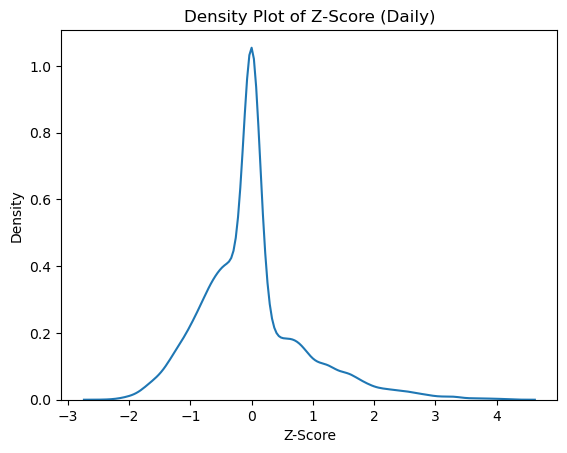

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(zscore_df['zscore'])
plt.xlabel('Z-Score')
plt.ylabel('Density')
plt.title('Density Plot of Z-Score (Daily)')
plt.show()

It seems that this distribution is centered on 0 between -2 and 2, so outliers would be less than -2 or greater than 2. We'll add this value to the original df. 

In [27]:
data['hourly_outlier_flag'] = np.where((zscore_df['zscore'] > 2) | (zscore_df['zscore'] < -2), 1, 0)


In [29]:
data[data['hourly_outlier_flag'].isnull()]

,time,orders,city,hour,day,hourly_outlier_flag
time,,,,,,


### Hourly spikes

In the EDA we identified spikes on an hourly level. 

In [30]:
spikes

,hour,day,spike
0,6,Tuesday,0
1,7,Tuesday,0
2,8,Tuesday,0
3,9,Tuesday,0
4,10,Tuesday,0
...,...,...,...
97,18,Sunday,0
98,19,Sunday,0
99,20,Sunday,1
100,21,Sunday,1


Let's append that to our dataset.

In [31]:
# Convert 'melted_spikes' DataFrame into a dictionary for faster lookup
spikes_dict = spikes.set_index(['day', 'hour'])['spike'].to_dict()

# Create 'hour' and 'day' columns in 'data' DataFrame
data['hour'] = data.index.hour
data['day'] = data.index.strftime('%A')  # This will return the day of the week

# Match the 'spike' value based on 'hour' and 'day'
data['weekly_seasonality'] = data.apply(lambda row: spikes_dict.get((row['day'], row['hour']), 0), axis=1)
data['weekly_seasonality'] = data['weekly_seasonality'].replace({"True":1, "False":0})

# Drop the 'hour' and 'day' columns
data.drop(columns=['hour', 'day'], inplace=True)


### August

We determined that August has a seasonality trend of low orders. Let's identify that as well. 

In [33]:
data['is_august'] = [1 if x.month == 8 else 0 for x in data.index]


In [34]:
data

,time,orders,city,hourly_outlier_flag,weekly_seasonality,is_august
time,,,,,,
2021-02-01 00:00:00,2021-02-01 00:00:00,0.0,BCN,0,0,0
2021-02-01 01:00:00,2021-02-01 01:00:00,0.0,BCN,0,0,0
2021-02-01 02:00:00,2021-02-01 02:00:00,0.0,BCN,0,0,0
2021-02-01 03:00:00,2021-02-01 03:00:00,0.0,BCN,0,0,0
2021-02-01 04:00:00,2021-02-01 04:00:00,0.0,BCN,0,0,0
...,...,...,...,...,...,...
2022-02-01 19:00:00,2022-02-01 19:00:00,101.0,BCN,0,0,0
2022-02-01 20:00:00,2022-02-01 20:00:00,266.0,BCN,0,0,0
2022-02-01 21:00:00,2022-02-01 21:00:00,298.0,BCN,0,1,0


### Weather

Let's add weather as a feature. First we should resample hourly, then add `tmin_avg` to the df `data`. 

In [36]:
df_weather_agg.set_index('DATE', inplace=True)
df_weather_agg = df_weather_agg.resample('H').ffill()


In [37]:
df_weather_agg

,prcp_sum,prcp_avg,tmax_avg,tmin_avg
DATE,,,,
2021-01-01 00:00:00,17.6,1.035294,8.294118,2.582353
2021-01-01 01:00:00,17.6,1.035294,8.294118,2.582353
2021-01-01 02:00:00,17.6,1.035294,8.294118,2.582353
2021-01-01 03:00:00,17.6,1.035294,8.294118,2.582353
2021-01-01 04:00:00,17.6,1.035294,8.294118,2.582353
...,...,...,...,...
2023-06-05 20:00:00,0.0,NaN,NaN,NaN
2023-06-05 21:00:00,0.0,NaN,NaN,NaN
2023-06-05 22:00:00,0.0,NaN,NaN,NaN


In [40]:
data = data.merge(df_weather_agg[['tmin_avg']], left_index=True, right_index=True, how='left')

## Model

### Preprocessing

#### Orders are floats

Intuitively none of the orders should be decimals, so these must be erroneous data points. Let's investigate. 

In [42]:

obs_with_float = data[data['orders'] % 1 != 0].copy()
obs_with_float

,time,orders,city,hourly_outlier_flag,weekly_seasonality,is_august,tmin_avg
time,,,,,,,
2021-08-01 06:00:00,2021-08-01 06:00:00,2.1,BCN,0,0,1,15.112500
2021-08-01 07:00:00,2021-08-01 07:00:00,0.7,BCN,0,0,1,15.112500
2021-08-01 08:00:00,2021-08-01 08:00:00,8.4,BCN,0,0,1,15.112500
2021-08-01 10:00:00,2021-08-01 10:00:00,25.2,BCN,0,0,1,15.112500
2021-08-01 11:00:00,2021-08-01 11:00:00,18.9,BCN,0,0,1,15.112500
...,...,...,...,...,...,...,...
2021-08-31 18:00:00,2021-08-31 18:00:00,25.9,BCN,0,0,1,18.129412
2021-08-31 19:00:00,2021-08-31 19:00:00,51.1,BCN,0,0,1,18.129412
2021-08-31 20:00:00,2021-08-31 20:00:00,150.5,BCN,0,0,1,18.129412


About 5% of observations are floats. This is weird, but let's determine whether or not they're similar to the orders from the previous week at that same time

In [43]:
obs_with_float['prev_week_orders'] = obs_with_float['orders'].shift(7*24).fillna(0)
obs_with_float['prev_week_orders_diff'] = (obs_with_float['orders'] / obs_with_float['prev_week_orders']).fillna(0)
obs_with_float['prev_week_orders_diff'] = obs_with_float['prev_week_orders_diff'].replace([np.inf, -np.inf], 0)

# Drop rows with missing values and sort by 'previous_day_orders_diff' in descending order
obs_with_float = obs_with_float.dropna().sort_values(by='prev_week_orders_diff', ascending=False)


/var/folders/y1/0lw69qj93m9fctnr1nh04c9c0000gn/T/ipykernel_48623/4085024886.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




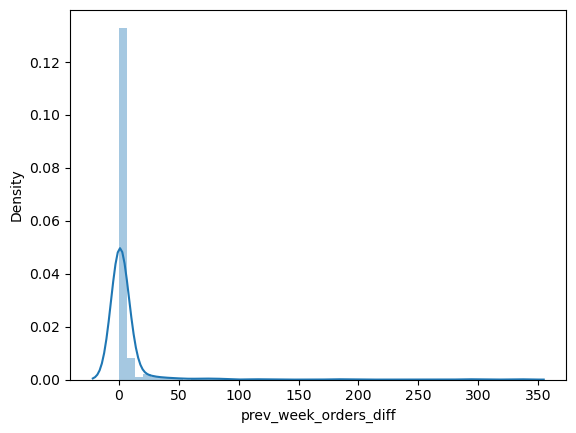

In [44]:
sns.distplot(obs_with_float['prev_week_orders_diff'])
plt.show()

There's a long tail here of really weird values. Most of the values here are between 0-0.1, which makes sense, but with the long tail I think it's best to impute the number from the previous week. 

In [45]:
def impute_previous_week_orders(data, column):
    imputed_values = data[column].copy()
    
    # Iterate over all instances in the data
    for date, value in data.iterrows():
        # Check if it's a float and if it does not end with .0
        if isinstance(value[column], float) and value[column] % 1 != 0:
            date_minus_one_week = date - pd.Timedelta(weeks=1)

            # Make sure the date is within the DataFrame's range
            while date_minus_one_week in data.index:
                # If the value from a week ago ends with .0, use it
                if isinstance(data.loc[date_minus_one_week, column], float) and data.loc[date_minus_one_week, column] % 1 == 0:
                    imputed_values.loc[date] = data.loc[date_minus_one_week, column]
                    break
                else:
                    # If the value from a week ago does not end with .0, check the week before that
                    date_minus_one_week -= pd.Timedelta(weeks=1)
            else:
                # If no appropriate value was found in the previous weeks, round the current value
                imputed_values.loc[date] = round(value[column])
                
    return imputed_values

data['orders'] = impute_previous_week_orders(data, 'orders')


In [47]:
data[data['orders'] % 1 != 0]

,time,orders,city,hourly_outlier_flag,weekly_seasonality,is_august,tmin_avg
time,,,,,,,


#### Hourly orders

There are some orders between hours 23-6 that have exactly 1 order. Since there are no other orders at that time, I'm going to assume this is an error

In [48]:
midnight_orders_mask = (data['time'].dt.hour.isin(list(range(0, 6)) + [23])) & (data['orders'].isin(list(range(1,2))))
midnight_orders = data[midnight_orders_mask].copy()
midnight_orders

,time,orders,city,hourly_outlier_flag,weekly_seasonality,is_august,tmin_avg
time,,,,,,,
2021-02-05 23:00:00,2021-02-05 23:00:00,1.0,BCN,1,0,0,9.300000
2021-02-26 23:00:00,2021-02-26 23:00:00,1.0,BCN,1,0,0,6.770588
2021-04-23 23:00:00,2021-04-23 23:00:00,1.0,BCN,1,0,0,6.052941
2021-05-16 23:00:00,2021-05-16 23:00:00,1.0,BCN,1,0,0,13.864706
2021-05-21 23:00:00,2021-05-21 23:00:00,1.0,BCN,1,0,0,11.976471
2021-07-09 23:00:00,2021-07-09 23:00:00,1.0,BCN,1,0,0,17.888235
2021-09-04 23:00:00,2021-09-04 23:00:00,1.0,BCN,1,0,0,17.982353
2021-09-05 23:00:00,2021-09-05 23:00:00,1.0,BCN,1,0,0,18.647059
2021-09-11 23:00:00,2021-09-11 23:00:00,1.0,BCN,1,0,0,16.582353


We'll impute these orders as 0

In [49]:
data.loc[midnight_orders_mask, 'orders'] = 0

#### Index consistency

We need to make sure the index covers every hour for each date in our dataset. 

In [55]:
# First, reindex your DataFrame
data = data.reindex(expected_index)

# Fill NaN values in each column
data['orders'] = data['orders'].fillna(0)
data['city'] = data['city'].fillna('BCN')
data['hourly_outlier_flag'] = data['hourly_outlier_flag'].fillna(0)
data['weekly_seasonality'] = data['weekly_seasonality'].fillna(0)
data['is_august'] = (data.index.month == 8).astype(int)
data['tmin_avg'] = data.groupby(data.index.date)['tmin_avg'].transform(lambda x: x.fillna(x.mean()))

data = data.drop(columns='time')


In [56]:
data[data.isna().any(axis=1)]

,orders,city,hourly_outlier_flag,weekly_seasonality,is_august,tmin_avg


Let's also make sure that the index has frequeny data

In [57]:
data.index = data.index.to_period('H')


#### Stationary check

Before we do any models, we need to determine whether or not the series is stationary. 

In [58]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(data['orders'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
   dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)


Results of Dickey-Fuller Test:
Test Statistic                -1.100045e+01
p-value                        6.703239e-20
#Lags Used                     3.700000e+01
Number of Observations Used    8.746000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


The P-value is quite small, so we can reject the null hypothesis that states the series is not stationary. Therefore we don't need to make it stationary in further preprocessing. 

### SARIMAX

#### Determining SARIMAX parameters

For simplicity, we're only going to use one feature. Let's just use weather for now. 

In [95]:
from sklearn.preprocessing import StandardScaler


df_sarimax = data[['orders', 'tmin_avg']].copy()

split_point = int(len(df_sarimax)* 0.8)

df_train_sarimax = df_sarimax.iloc[:split_point]
df_test_sarimax = df_sarimax.iloc[split_point:]

# initialize a scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform both the training and test data.
df_train_scaled_sarimax = pd.DataFrame(scaler.fit_transform(df_train_sarimax), columns=df_train_sarimax.columns, index=df_train_sarimax.index)
df_test_scaled_sarimax = pd.DataFrame(scaler.transform(df_test_sarimax), columns=df_test_sarimax.columns, index=df_test_sarimax.index)


First we need to determine the appropriate $(p, q, r)$ hyperparameter values. We can do this by plotting the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)

In [96]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from sklearn.metrics import mean_squared_error

# Function to calculate SMAPE
def calculate_smape(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

p = d = q = range(0, 2) # non-seasonal parameters
P = D = Q = range(0, 2) # seasonal parameters
s = 12 # seasonal period, you can adjust it according to your data
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(P, D, Q))]

best_smape = np.inf
best_mse = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

# iterate over all combinations
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            temp_model = SARIMAX(df_train_scaled_sarimax['orders'],
                                 exog=df_train_scaled_sarimax['tmin_avg'],
                                 order=param,
                                 seasonal_order=param_seasonal,
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
            results = temp_model.fit()

            # Predict for the test set
            predicted_values = results.predict(start=len(df_train_scaled_sarimax), 
                                               end=len(df_train_scaled_sarimax) + len(df_test_scaled_sarimax) - 1, 
                                               exog=df_test_scaled_sarimax['tmin_avg'])

            # Calculate metrics for the test set
            temp_smape = calculate_smape(df_test_scaled_sarimax['orders'], predicted_values)
            temp_mse = mean_squared_error(df_test_scaled_sarimax['orders'], predicted_values)

            if temp_smape < best_smape and temp_mse < best_mse:
                best_smape = temp_smape
                best_mse = temp_mse
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except Exception as e:
            print(f"{e}")
            continue

print(f"Best SARIMAX{best_pdq} with seasonality: {best_seasonal_pdq} model - SMAPE: {best_smape}, MSE: {best_mse}")


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.34646D+00    |proj g|=  1.19324D-02

At iterate    5    f=  1.41823D+00    |proj g|=  1.88094D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     19      1     0     0   9.008D-08   1.418D+00
  F =   1.4182328816216367     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05855D+00    |proj g|=  3.71053D-01


 This problem is unconstrained.



At iterate    5    f=  1.02436D+00    |proj g|=  1.01196D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   6.651D-07   1.024D+00
  F =   1.0243558975353417     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.24023D-01    |proj g|=  1.89975D-01


 This problem is unconstrained.



At iterate    5    f=  9.18118D-01    |proj g|=  1.17529D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   2.338D-06   9.181D-01
  F =  0.91811812992034914     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.18317D-01    |proj g|=  1.67486D-01


 This problem is unconstrained.



At iterate    5    f=  9.14140D-01    |proj g|=  5.67059D-03

At iterate   10    f=  9.14080D-01    |proj g|=  5.24244D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   5.242D-05   9.141D-01
  F =  0.91407977950617858     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22165D-01    |proj g|=  2.33545D-01


 This problem is unconstrained.



At iterate    5    f=  9.12693D-01    |proj g|=  2.28622D-03

At iterate   10    f=  9.12679D-01    |proj g|=  1.26802D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     15      1     0     0   1.612D-05   9.127D-01
  F =  0.91267852687187201     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.12629D+00    |proj g|=  1.48588D-02
  ys=-2.674E+02  -gs= 1.007E+00 BFGS update SKIPPED


 This problem is unconstrained.



At iterate    5    f=  1.20378D+00    |proj g|=  1.57038D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     22      2     1     0   2.247D-06   1.199D+00
  F =   1.1987206254839944     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10697D+00    |proj g|=  1.66713D-01


 This problem is unconstrained.



At iterate    5    f=  1.08510D+00    |proj g|=  7.09889D-04

At iterate   10    f=  1.08508D+00    |proj g|=  3.37168D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     17      1     0     0   8.532D-06   1.085D+00
  F =   1.0850768969190301     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08793D+00    |proj g|=  6.18265D-01

At iterate    5    f=  1.05322D+00    |proj g|=  2.67993D-02

At iterate   10    f=  1.02683D+00    |proj g|=  4.62029D-01

At iterate   15    f=  1.02415D+00    |proj g|=  1.60192D-03

At iterate   20    f=  1.02415D+00    |proj g|=  9.68330D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     46      1     0     0   9.683D-05   1.024D+00
  F =   1.0241505088218146     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  9.18546D-01    |proj g|=  3.20346D-01

At iterate   10    f=  9.18245D-01    |proj g|=  1.64308D-02

At iterate   15    f=  9.18232D-01    |proj g|=  4.36692D-03

At iterate   20    f=  9.18231D-01    |proj g|=  8.11386D-03

At iterate   25    f=  9.18227D-01    |proj g|=  4.01667D-03

At iterate   30    f=  9.18227D-01    |proj g|=  1.88651D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     44      1     0     0   1.333D-04   9.182D-01
  F =  0.91822671740884565     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.58651D-01    |proj g|=  1.95041D-01

At iterate    5    f=  9.18696D-01    |proj g|=  1.41036D-01

At iterate   10    f=  9.14927D-01    |proj g|=  3.83337D-02

At iterate   15    f=  9.14252D-01    |proj g|=  7.97788D-03

At iterate   20    f=  9.14248D-01    |proj g|=  8.28475D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     39      1     0     0   4.358D-05   9.142D-01
  F =  0.91424758986813359     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.31333D+00    |proj g|=  1.23122D-02

At iterate    5    f=  1.38640D+00    |proj g|=  3.55854D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     22      1     0     0   3.644D-06   1.386D+00
  F =   1.3863967601516916     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  1.20867D+00    |proj g|=  5.32618D-01

At iterate   10    f=  1.19971D+00    |proj g|=  1.13551D-01

At iterate   15    f=  1.19908D+00    |proj g|=  2.13741D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     37      1     0     0   2.137D-04   1.199D+00
  F =   1.1990782649175815     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12313D+00    |proj g|=  4.33001D-01


 This problem is unconstrained.



At iterate    5    f=  1.08633D+00    |proj g|=  2.96714D-01

At iterate   10    f=  1.08545D+00    |proj g|=  1.29236D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     28      1     0     0   3.344D-04   1.085D+00
  F =   1.0854424638550544     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20758D+00    |proj g|=  3.47651D-01


 This problem is unconstrained.


  ys=-1.945E-03  -gs= 4.408E-02 BFGS update SKIPPED

At iterate    5    f=  1.08046D+00    |proj g|=  4.03996D-01

At iterate   10    f=  1.06113D+00    |proj g|=  5.49646D-01

At iterate   15    f=  1.02728D+00    |proj g|=  7.63382D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     70      1     1     0   5.621D+00   1.026D+00
  F =   1.0263278565693810     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0  

 This problem is unconstrained.



At iterate    5    f=  1.01164D+00    |proj g|=  4.42952D-01

At iterate   10    f=  9.41824D-01    |proj g|=  7.38491D+00

At iterate   15    f=  9.25427D-01    |proj g|=  3.20221D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     79      2     0     0   1.177D+00   9.253D-01
  F =  0.92533891909618959     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.68261D+00    |proj g|=  8.50119D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3     18      1     0     0   7.784D-06   1.756D+00
  F =   1.7563020601976078     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55615D+00    |proj g|=  3.51576D-01


 This problem is unconstrained.



At iterate    5    f=  1.38781D+00    |proj g|=  3.77036D-01

At iterate   10    f=  1.38670D+00    |proj g|=  2.49968D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     21      1     0     0   2.500D-03   1.387D+00
  F =   1.3867001028437376     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53329D+00    |proj g|=  3.48594D-01


 This problem is unconstrained.



At iterate    5    f=  1.40641D+00    |proj g|=  5.51261D-02

At iterate   10    f=  1.26072D+00    |proj g|=  1.20282D+01

At iterate   15    f=  1.20040D+00    |proj g|=  1.66701D+00

At iterate   20    f=  1.20000D+00    |proj g|=  2.46051D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     51      1     0     0   1.721D-02   1.200D+00
  F =   1.2000031904653259     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52538D+00    |proj g|=  3.58319D-01
  ys=-2.427E-01  -gs= 1.932E-01 BFGS update SKIPPED

At iterate    5    f=  1.23526D+00    |proj g|=  1.35844D+00

At iterate   10    f=  1.12460D+00    |proj g|=  9.82419D+00

At iterate   15    f=  1.09248D+00    |proj g|=  6.09415D-01

At iterate   20    f=  1.08697D+00    |proj g|=  2.40847D+00

At iterate   25    f=  1.08634D+00    |proj g|=  2.53118D-01

At iterate   30    f=  1.08633D+00    |proj g|=  1.68010D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31    111      3     1     0   1.680D-03   1.086D+00
  F =   1.0863324702111623     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE



 This problem is unconstrained.


           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48714D+00    |proj g|=  4.17764D-01

At iterate    5    f=  1.18824D+00    |proj g|=  2.81541D+00

At iterate   10    f=  1.11382D+00    |proj g|=  5.39855D-01

At iterate   15    f=  1.10848D+00    |proj g|=  3.26947D-01

At iterate   20    f=  1.08200D+00    |proj g|=  3.51928D+00

At iterate   25    f=  1.05354D+00    |proj g|=  2.28519D+00
  ys=-2.197E-09  -gs= 6.133E-08 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28    162      3     1     0   8.753D-01   1.054D+00
  F =   1.0535152937362535     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.15352D+00    |proj g|=  5.30161D-03
  ys=-1.741E+01  -gs= 9.853E-01 BFGS update SKIPPED

At iterate    5    f=  2.22785D+00    |proj g|=  2.24032D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of fu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.77199D+00    |proj g|=  4.07035D-01

At iterate    5    f=  1.75650D+00    |proj g|=  1.69612D-03

At iterate   10    f=  1.75650D+00    |proj g|=  1.17594D-02

At iterate   15    f=  1.75650D+00    |proj g|=  7.15825D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     27      1     0     0   1.480D-04   1.756D+00
  F =   1.7564962518724896     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  1.62827D+00    |proj g|=  1.01051D+00

At iterate   10    f=  1.42514D+00    |proj g|=  9.75934D-01

At iterate   15    f=  1.40535D+00    |proj g|=  5.17716D-01

At iterate   20    f=  1.40501D+00    |proj g|=  1.08539D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     56      1     0     0   8.401D-04   1.405D+00
  F =   1.4049978932840617     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73698D+00    |proj g|=  8.76492D-01

At iterate    5    f=  1.46498D+00    |proj g|=  4.42577D-01

At iterate   10    f=  1.42969D+00    |proj g|=  2.74481D-01

At iterate   15    f=  1.39827D+00    |proj g|=  8.38224D-01

At iterate   20    f=  1.32047D+00    |proj g|=  2.33075D+01

At iterate   25    f=  1.21478D+00    |proj g|=  1.94590D+01
  ys=-6.035E-04  -gs= 1.826E-02 BFGS update SKIPPED

At iterate   30    f=  1.20755D+00    |proj g|=  1.85887D+02
  ys=-1.160E-10  -gs= 5.352E-09 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35    208      3     2     0   1.507D+02   1.206D+00
  F =   1.2057986968422469     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89465D+00    |proj g|=  3.71298D-01


 This problem is unconstrained.



At iterate    5    f=  1.37093D+00    |proj g|=  3.93556D-01

At iterate   10    f=  1.33866D+00    |proj g|=  1.25064D+00

At iterate   15    f=  1.33333D+00    |proj g|=  3.21541D-01

At iterate   20    f=  1.21217D+00    |proj g|=  2.17161D+01

At iterate   25    f=  1.12983D+00    |proj g|=  2.04937D+00

At iterate   30    f=  1.11317D+00    |proj g|=  3.57157D+00

At iterate   35    f=  1.10329D+00    |proj g|=  7.43506D+01
  ys=-2.425E-12  -gs= 3.707E-10 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39    181      2     1     0   6.165D+01   1.103D+00
  F =   1.1032858759597630     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11094D+00    |proj g|=  1.72075D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      6      1     0     0   1.351D-05   1.111D+00
  F =   1.1109388592286020     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.53896D-01    |proj g|=  3.96227D-01


 This problem is unconstrained.



At iterate    5    f=  9.35808D-01    |proj g|=  1.35076D-02

At iterate   10    f=  9.35689D-01    |proj g|=  7.75482D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     14      1     0     0   1.341D-06   9.357D-01
  F =  0.93568893503271067     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16396D-01    |proj g|=  4.91721D-02

At iterate    5    f=  9.15095D-01    |proj g|=  1.68847D-02

At iterate   10    f=  9.14933D-01    |proj g|=  5.70824D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     16      1     0     0   3.998D-05   9.149D-01
  F =  0.91493312496419676     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  9.14860D-01    |proj g|=  5.13209D-03

At iterate   10    f=  9.14727D-01    |proj g|=  1.43484D-02

At iterate   15    f=  9.13659D-01    |proj g|=  4.53622D-03

At iterate   20    f=  9.13622D-01    |proj g|=  2.05686D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     25      1     0     0   1.728D-05   9.136D-01
  F =  0.91362185510573857     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  9.08895D-01    |proj g|=  1.94489D-02

At iterate   10    f=  9.06780D-01    |proj g|=  1.72762D-02

At iterate   15    f=  9.06479D-01    |proj g|=  2.87586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     16     21      1     0     0   1.217D-05   9.065D-01
  F =  0.90647926158348391     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16031D+00    |proj g|=  1.31544D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.08043D+00    |proj g|=  4.82426D-02

At iterate   10    f=  1.07979D+00    |proj g|=  1.52269D-03

At iterate   15    f=  1.07977D+00    |proj g|=  2.31679D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   5.837D-06   1.080D+00
  F =   1.0797732133873645     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04862D+00    |proj g|=  3.04986D-01


 This problem is unconstrained.



At iterate    5    f=  9.41770D-01    |proj g|=  2.34629D-01

At iterate   10    f=  9.37172D-01    |proj g|=  8.35734D-02

At iterate   15    f=  9.35999D-01    |proj g|=  3.04995D-03

At iterate   20    f=  9.35986D-01    |proj g|=  2.68086D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     43      1     0     0   1.979D-05   9.360D-01
  F =  0.93598545303719327     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  9.16631D-01    |proj g|=  3.10410D-02

At iterate   10    f=  9.15770D-01    |proj g|=  1.71263D-02

At iterate   15    f=  9.15542D-01    |proj g|=  1.26541D-01

At iterate   20    f=  9.15164D-01    |proj g|=  2.14424D-02

At iterate   25    f=  9.15152D-01    |proj g|=  3.89809D-03

At iterate   30    f=  9.15128D-01    |proj g|=  1.19390D-02

At iterate   35    f=  9.15126D-01    |proj g|=  3.44715D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     49      1     0     0   6.092D-07   9.151D-01
  F =  0.91512604273509757     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  9.19174D-01    |proj g|=  6.61284D-02

At iterate   10    f=  9.15747D-01    |proj g|=  3.36681D-02

At iterate   15    f=  9.15659D-01    |proj g|=  3.98420D-02

At iterate   20    f=  9.15640D-01    |proj g|=  8.39460D-03

At iterate   25    f=  9.15580D-01    |proj g|=  2.76233D-02

At iterate   30    f=  9.15519D-01    |proj g|=  9.96545D-03

At iterate   35    f=  9.15436D-01    |proj g|=  6.62529D-03

At iterate   40    f=  9.15235D-01    |proj g|=  4.83423D-02

At iterate   45    f=  9.14162D-01    |proj g|=  4.74330D-02


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 This problem is unconstrained.



At iterate   50    f=  9.13746D-01    |proj g|=  4.17323D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   4.173D-03   9.137D-01
  F =  0.91374620312137977     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38522D+00    |proj g|=  3.36035D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.



At iterate    5    f=  1.17448D+00    |proj g|=  1.99002D-01

At iterate   10    f=  1.16070D+00    |proj g|=  2.94392D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     32      1     0     0   2.944D-04   1.161D+00
  F =   1.1606995474200805     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16752D+00    |proj g|=  3.62680D-01


 This problem is unconstrained.



At iterate    5    f=  1.08788D+00    |proj g|=  2.99574D-01

At iterate   10    f=  1.08334D+00    |proj g|=  1.18979D-01

At iterate   15    f=  1.08050D+00    |proj g|=  2.48272D-01

At iterate   20    f=  1.08013D+00    |proj g|=  5.04084D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     27      1     0     0   5.041D-04   1.080D+00
  F =   1.0801331164971637     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.07629D+00    |proj g|=  1.98518D-01

At iterate   10    f=  1.07564D+00    |proj g|=  2.44586D-01

At iterate   15    f=  1.06603D+00    |proj g|=  5.68465D-01

At iterate   20    f=  9.89545D-01    |proj g|=  4.84140D+00

At iterate   25    f=  9.54280D-01    |proj g|=  4.02525D+00

At iterate   30    f=  9.52700D-01    |proj g|=  2.66168D+00

At iterate   35    f=  9.38687D-01    |proj g|=  2.15668D+00

At iterate   40    f=  9.37804D-01    |proj g|=  7.07940D+01

At iterate   45    f=  9.37046D-01    |proj g|=  8.91227D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     84   

 This problem is unconstrained.



At iterate    5    f=  1.02186D+00    |proj g|=  2.36434D-01

At iterate   10    f=  9.72148D-01    |proj g|=  7.40187D-01

At iterate   15    f=  9.35471D-01    |proj g|=  1.02104D+01

At iterate   20    f=  9.29648D-01    |proj g|=  1.60556D+01

At iterate   25    f=  9.28890D-01    |proj g|=  1.11786D+01

At iterate   30    f=  9.28870D-01    |proj g|=  3.73446D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32    130      2     0     0   3.360D+00   9.289D-01
  F =  0.92886954153868928     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71387D+00    |proj g|=  2.06027D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.



At iterate    5    f=  1.38654D+00    |proj g|=  3.02090D-01

At iterate   10    f=  1.38555D+00    |proj g|=  8.72902D-03

At iterate   15    f=  1.38554D+00    |proj g|=  9.97059D-03

At iterate   20    f=  1.38554D+00    |proj g|=  1.08301D-02

At iterate   25    f=  1.38554D+00    |proj g|=  2.01830D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     36      1     0     0   5.674D-05   1.386D+00
  F =   1.3855399086501505     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.36898D+00    |proj g|=  4.52408D-02

At iterate   10    f=  1.36757D+00    |proj g|=  1.98881D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     31      1     0     0   9.418D-04   1.367D+00
  F =   1.3674148459534838     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53007D+00    |proj g|=  3.08975D-01

At iterate    5    f=  1.24080D+00    |proj g|=  4.84803D-01

At iterate   10    f=  1.13310D+00    |proj g|=  8.55722D-01

At iterate   15    f=  1.08807D+00    |proj g|=  5.01888D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f=  1.08103D+00    |proj g|=  3.96428D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46    131      2     0     0   3.727D-03   1.081D+00
  F =   1.0810296010130380     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47878D+00    |proj g|=  4.17847D-01


 This problem is unconstrained.



At iterate    5    f=  1.10554D+00    |proj g|=  8.68115D-01

At iterate   10    f=  1.09409D+00    |proj g|=  1.60996D+00

At iterate   15    f=  1.09190D+00    |proj g|=  1.44521D+00

At iterate   20    f=  1.08811D+00    |proj g|=  6.07355D-01

At iterate   25    f=  1.08760D+00    |proj g|=  2.85885D-01

At iterate   30    f=  1.08724D+00    |proj g|=  1.39228D+00

At iterate   35    f=  1.08684D+00    |proj g|=  7.47744D-02

At iterate   40    f=  1.08477D+00    |proj g|=  7.64499D-01

At iterate   45    f=  1.08355D+00    |proj g|=  8.82811D-02


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 This problem is unconstrained.



At iterate   50    f=  1.08323D+00    |proj g|=  1.82366D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     90      1     0     0   1.824D+00   1.083D+00
  F =   1.0832292804085366     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11515D+00    |proj g|=  3.09318D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.



At iterate    5    f=  1.71911D+00    |proj g|=  4.71588D-01

At iterate   10    f=  1.71413D+00    |proj g|=  5.65742D-03

At iterate   15    f=  1.71411D+00    |proj g|=  2.40711D-03

At iterate   20    f=  1.71411D+00    |proj g|=  9.60723D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     35      1     0     0   2.922D-04   1.714D+00
  F =   1.7141051118094497     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.74394D+00    |proj g|=  2.22588D-01

At iterate   10    f=  1.74178D+00    |proj g|=  3.20998D-01
  ys=-1.274E-01  -gs= 5.097E-02 BFGS update SKIPPED

At iterate   15    f=  1.60246D+00    |proj g|=  3.65804D-01

At iterate   20    f=  1.42417D+00    |proj g|=  1.38161D+01

At iterate   25    f=  1.38648D+00    |proj g|=  6.43251D-01

At iterate   30    f=  1.38637D+00    |proj g|=  4.91767D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     83      1     1     0   4.969D-03   1.386D+00
  F =   1.3863673833477146     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.77537D+00    |proj g|=  5.40084D-01

At iterate    5    f=  1.46615D+00    |proj g|=  3.27040D+00

At iterate   10    f=  1.37117D+00    |proj g|=  3.14714D-01

At iterate   15    f=  1.36955D+00    |proj g|=  8.40835D-02

At iterate   20    f=  1.36943D+00    |proj g|=  1.06021D-01

At iterate   25    f=  1.36931D+00    |proj g|=  8.32055D-02

At iterate   30    f=  1.36930D+00    |proj g|=  3.44357D-02

At iterate   35    f=  1.36867D+00    |proj g|=  3.76977D-01

At iterate   40    f=  1.36824D+00    |proj g|=  4.31042D-01

At iterate   45    f=  1.36819D+00    |proj g|=  8.75657D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  1.37010D+00    |proj g|=  8.64097D-01

At iterate   10    f=  1.30631D+00    |proj g|=  5.99610D-01

At iterate   15    f=  1.17056D+00    |proj g|=  9.82189D+01

At iterate   20    f=  1.15282D+00    |proj g|=  2.49285D+01

At iterate   25    f=  1.14869D+00    |proj g|=  3.48371D+00
  ys=-4.596E-18  -gs= 2.910E-16 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-3.067E-16  -gs= 9.793E-14 BFGS update SKIPPED
  ys=-6.314E-19  -gs= 1.734E-15 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29    190      3     3     0   6.614D-01   1.149D+00
  F =   1.1486639789248814     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.55796D-01    |proj g|=  1.91671D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.



At iterate    5    f=  9.13077D-01    |proj g|=  2.72204D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   2.070D-05   9.131D-01
  F =  0.91306900226521825     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12542D-01    |proj g|=  1.41058D-02


 This problem is unconstrained.



At iterate    5    f=  9.12468D-01    |proj g|=  1.52179D-03

At iterate   10    f=  9.12379D-01    |proj g|=  7.35777D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     16      1     0     0   2.596D-05   9.124D-01
  F =  0.91237895598676777     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.34199D-01    |proj g|=  1.45814D-01


 This problem is unconstrained.



At iterate    5    f=  9.12995D-01    |proj g|=  6.42815D-02

At iterate   10    f=  9.12451D-01    |proj g|=  1.30959D-03

At iterate   15    f=  9.08209D-01    |proj g|=  7.59926D-02

At iterate   20    f=  9.06646D-01    |proj g|=  5.18188D-03

At iterate   25    f=  9.06641D-01    |proj g|=  2.69594D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     42      1     0     0   5.900D-06   9.066D-01
  F =  0.90664079646034323     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.08269D-01    |proj g|=  6.08470D-02

At iterate    5    f=  9.06325D-01    |proj g|=  1.19145D-02

At iterate   10    f=  9.05964D-01    |proj g|=  1.24014D-03

At iterate   15    f=  8.81847D-01    |proj g|=  2.12838D-01

At iterate   20    f=  8.64951D-01    |proj g|=  8.68885D-02

At iterate   25    f=  8.62580D-01    |proj g|=  1.40990D-02

At iterate   30    f=  8.62469D-01    |proj g|=  4.67818D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01905D+00    |proj g|=  7.86774D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      7      1     0     0   8.995D-06   1.019D+00
  F =   1.0190154574522758     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01766D+00    |proj g|=  2.07681D-02

At iterate    5    f=  1.00604D+00    |proj g|=  2.13133D-01

At iterate   10    f=  9.57498D-01    |proj g|=  5.95205D-02

At iterate   15    f=  9.55982D-01    |proj g|=  7.22422D-03

At iterate   20    f=  9.55892D-01    |proj g|=  9.50775D-03

At iterate   25    f=  9.55884D-01    |proj g|=  3.31702D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     46      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  9.13590D-01    |proj g|=  2.31500D-01

At iterate   10    f=  9.13341D-01    |proj g|=  2.46448D-02

At iterate   15    f=  9.13311D-01    |proj g|=  1.07198D-01

At iterate   20    f=  9.13268D-01    |proj g|=  3.68155D-02

At iterate   25    f=  9.13264D-01    |proj g|=  1.37011D-02

At iterate   30    f=  9.13232D-01    |proj g|=  3.60700D-02

At iterate   35    f=  9.13225D-01    |proj g|=  1.21802D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     47      1     0     0   1.218D-03   9.132D-01
  F =  0.91322452747202587     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  9.30369D-01    |proj g|=  1.83777D-01

At iterate   10    f=  9.14154D-01    |proj g|=  2.94582D-01

At iterate   15    f=  9.13408D-01    |proj g|=  3.33666D-02

At iterate   20    f=  9.13395D-01    |proj g|=  3.91947D-03

At iterate   25    f=  9.13391D-01    |proj g|=  2.06217D-02

At iterate   30    f=  9.13329D-01    |proj g|=  1.18339D-01

At iterate   35    f=  9.13215D-01    |proj g|=  2.87688D-02

At iterate   40    f=  9.13086D-01    |proj g|=  2.84537D-02

At iterate   45    f=  9.12900D-01    |proj g|=  1.86389D-02


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 This problem is unconstrained.



At iterate   50    f=  9.12547D-01    |proj g|=  3.96915D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     71      1     0     0   3.969D-03   9.125D-01
  F =  0.91254675260897999     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75989D-01    |proj g|=  1.03754D-01
  ys=-2.127E-01  -gs= 3.699E-02 BFGS update SKIPPED

At iterate    5    f=  9.30227D-01    |proj g|=  2.11936D-01

At iterate   10  

/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 This problem is unconstrained.



At iterate   50    f=  9.11866D-01    |proj g|=  1.17207D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68      2     1     0   1.172D-02   9.119D-01
  F =  0.91186574205595772     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23988D+00    |proj g|=  5.24894D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.


  ys=-1.252E-01  -gs= 5.789E-02 BFGS update SKIPPED

At iterate    5    f=  1.04141D+00    |proj g|=  5.51725D-01

At iterate   10    f=  1.01997D+00    |proj g|=  3.56588D-01

At iterate   15    f=  1.01959D+00    |proj g|=  1.58878D-02

At iterate   20    f=  1.01958D+00    |proj g|=  5.56999D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     35      1     1     0   3.139D-04   1.020D+00
  F =   1.0195766033888674     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0   

 This problem is unconstrained.



At iterate    5    f=  1.04294D+00    |proj g|=  3.22356D-01

At iterate   10    f=  1.04001D+00    |proj g|=  1.17571D-01

At iterate   15    f=  1.02194D+00    |proj g|=  5.67222D-02

At iterate   20    f=  9.71346D-01    |proj g|=  1.97844D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     85      2     0     0   8.563D+00   9.585D-01
  F =  0.95854610716030053     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09649D+00    |proj g|=  3.48187D-01

At iterate    5    f=  1.03381D+00    |proj g|=  5.34803D-02

At iterate   10    f=  1.00616D+00    |proj g|=  1.06487D+00

At iterate   15    f=  9.57215D-01    |proj g|=  8.00278D+00

At iter

 This problem is unconstrained.



At iterate    5    f=  1.07722D+00    |proj g|=  1.87859D-01

At iterate   10    f=  1.07610D+00    |proj g|=  1.68248D-01

At iterate   15    f=  1.07181D+00    |proj g|=  2.46393D-01

At iterate   20    f=  1.05613D+00    |proj g|=  2.12327D-01

At iterate   25    f=  1.05377D+00    |proj g|=  8.20001D-02
  ys=-7.501E-02  -gs= 6.033E-03 BFGS update SKIPPED

At iterate   30    f=  9.66182D-01    |proj g|=  2.57479D+00

At iterate   35    f=  9.24638D-01    |proj g|=  9.73667D+00

At iterate   40    f=  9.17041D-01    |proj g|=  6.80886D+00

At iterate   45    f=  9.16788D-01    |proj g|=  2.00063D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41240D+00    |proj g|=  3.43690D-01

At iterate    5    f=  1.24175D+00    |proj g|=  8.13543D-02

At iterate   10    f=  1.24039D+00    |proj g|=  1.64529D-04

At iterate   15    f=  1.24039D+00    |proj g|=  1.20549D-03

At iterate   20    f=  1.24039D+00    |proj g|=  8.90861D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     29      1     0     0   8.909D-06   1.240D+00
  F =   1.2403877644762609     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  1.29634D+00    |proj g|=  3.14342D-01

At iterate   10    f=  1.24816D+00    |proj g|=  2.83082D-01
  ys=-1.834E-01  -gs= 8.498E-02 BFGS update SKIPPED

At iterate   15    f=  1.03428D+00    |proj g|=  3.41687D+00

At iterate   20    f=  1.02683D+00    |proj g|=  1.63959D+00

At iterate   25    f=  1.02373D+00    |proj g|=  6.55670D-01

At iterate   30    f=  1.02092D+00    |proj g|=  7.56663D-01

At iterate   35    f=  1.02062D+00    |proj g|=  3.58862D-01

At iterate   40    f=  1.02062D+00    |proj g|=  1.14244D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     92      1     1

 This problem is unconstrained.



At iterate    5    f=  1.29118D+00    |proj g|=  2.48008D-01

At iterate   10    f=  1.27039D+00    |proj g|=  2.93827D-01
  ys=-1.547E-01  -gs= 6.398E-02 BFGS update SKIPPED

At iterate   15    f=  1.03968D+00    |proj g|=  1.94270D+00

At iterate   20    f=  1.03761D+00    |proj g|=  5.02248D-01

At iterate   25    f=  1.03757D+00    |proj g|=  4.67900D-01

At iterate   30    f=  1.03736D+00    |proj g|=  6.77857D-02

At iterate   35    f=  1.03694D+00    |proj g|=  4.70385D-01

At iterate   40    f=  1.03692D+00    |proj g|=  1.57811D-01

At iterate   45    f=  1.03515D+00    |proj g|=  1.02227D+00


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  1.02050D+00    |proj g|=  1.16832D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     86      1     1     0   1.168D+01   1.021D+00
  F =   1.0205010026858237     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51206D+00    |proj g|=  2.14613D-01


 This problem is unconstrained.



At iterate    5    f=  1.35086D+00    |proj g|=  4.07650D-01

At iterate   10    f=  1.27640D+00    |proj g|=  3.98848D-01
  ys=-3.285E-01  -gs= 3.352E-02 BFGS update SKIPPED

At iterate   15    f=  1.17154D+00    |proj g|=  6.74403D-01

At iterate   20    f=  1.05601D+00    |proj g|=  6.20341D-01

At iterate   25    f=  1.05407D+00    |proj g|=  4.04490D-01

At iterate   30    f=  1.05235D+00    |proj g|=  4.03905D-01

At iterate   35    f=  1.05218D+00    |proj g|=  5.50469D-01

At iterate   40    f=  1.05133D+00    |proj g|=  1.42684D-01

At iterate   45    f=  1.05025D+00    |proj g|=  7.45321D-01


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 This problem is unconstrained.



At iterate   50    f=  1.04233D+00    |proj g|=  1.47302D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     99      1     1     0   1.473D+00   1.042D+00
  F =   1.0423294300304189     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91643D+00    |proj g|=  5.18814D-05

At iterate    5    f=  1.91643D+00    |proj g|=  3.25140D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate    5    f=  1.54937D+00    |proj g|=  4.89769D-01

At iterate   10    f=  1.54127D+00    |proj g|=  1.20405D-02

At iterate   15    f=  1.54126D+00    |proj g|=  2.59250D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     27      1     0     0   7.987D-05   1.541D+00
  F =   1.5412632075377573     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64810D+00    |proj g|=  6.11258D-01


 This problem is unconstrained.



At iterate    5    f=  1.56087D+00    |proj g|=  5.39210D-01

At iterate   10    f=  1.36856D+00    |proj g|=  6.51429D-01
  ys=-5.256E-02  -gs= 1.310E-01 BFGS update SKIPPED

At iterate   15    f=  1.26482D+00    |proj g|=  1.20599D+00

At iterate   20    f=  1.24355D+00    |proj g|=  7.19657D-01

At iterate   25    f=  1.24275D+00    |proj g|=  5.48471D-01

At iterate   30    f=  1.24136D+00    |proj g|=  6.16226D-02

At iterate   35    f=  1.24132D+00    |proj g|=  3.61668D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35    108      1     1     0   3.617D-02   1.241D+00
  F =   1.2413207118093730     

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80252D+00    |proj g|=  2.38820D-01
  ys=-2.048E-03  -gs= 6.265E-02 BFGS update SKIPPED

At iterate    5    f=  1.56495D+00    |proj g|=  4.37713D-01

At iterate   10    f=  1.33380D+00    |proj g|=  2.11197D+01

At iterate   15    f=  1.28051D+00    |proj g|=  4.73310D-01

At iterate   20    f=  1.27425D+00    |proj g|=  7.82096D-02

At iterate   25    f=  1.27181D+00    |proj g|=  1.46991D-01

At iterate   30    f=  1.27157D+00    |proj g|=  8.66545D-01

At iterate   35    f=  1.25265D+00    |proj g|=  1.46947D+00

At iterate   40    f=  1.18507D+00    |proj g|=  4.43785D+00

At iterate   45    f=  1.18240D+00    |proj g|=  2.64580D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy search

 This problem is unconstrained.


  ys=-3.667E-01  -gs= 1.669E-01 BFGS update SKIPPED

At iterate    5    f=  1.37834D+00    |proj g|=  5.72551D-01

At iterate   10    f=  1.29929D+00    |proj g|=  8.07202D-01

At iterate   15    f=  1.28642D+00    |proj g|=  3.14753D-01

At iterate   20    f=  1.28603D+00    |proj g|=  3.61791D-01

At iterate   25    f=  1.28476D+00    |proj g|=  4.65188D-01

At iterate   30    f=  1.28259D+00    |proj g|=  3.18163D-01

At iterate   35    f=  1.28196D+00    |proj g|=  1.89406D+00

At iterate   40    f=  1.22705D+00    |proj g|=  1.32873D+02

At iterate   45    f=  1.09908D+00    |proj g|=  1.52729D+01


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  1.07376D+00    |proj g|=  3.38698D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50    144      1     1     0   3.387D+01   1.074D+00
  F =   1.0737589144788113     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.25716D-01    |proj g|=  3.55997D-04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3      6      1     0     0   4.635D-07   9.257D-01
  F =  0.92571621616811650     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16257D-01    |proj g|=  3.28458D-02


 This problem is unconstrained.



At iterate    5    f=  9.14092D-01    |proj g|=  2.83938D-02

At iterate   10    f=  9.12817D-01    |proj g|=  3.72341D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     19      1     0     0   1.649D-05   9.128D-01
  F =  0.91281735579230050     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17875D+00    |proj g|=  4.44003D-01


 This problem is unconstrained.



At iterate    5    f=  9.11702D-01    |proj g|=  8.40912D-02

At iterate   10    f=  9.09824D-01    |proj g|=  2.13363D-02

At iterate   15    f=  9.02749D-01    |proj g|=  1.31576D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     66      1     0     0   7.002D-01   9.023D-01
  F =  0.90227006239219421     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.43690D-01    |proj g|=  1.89484D-01

At iterate    5    f=  9.30089D-01    |proj g|=  7.45454D-02

At iterate   10    f=  9.09607D-01    |proj g|=  1.33496D-01

At iterate   15    f=  9.06624D-01    |proj g|=  5.42585D-03

At iter

 This problem is unconstrained.



At iterate    5    f=  9.06451D-01    |proj g|=  5.86523D-02

At iterate   10    f=  8.91422D-01    |proj g|=  1.00778D+00

At iterate   15    f=  8.60636D-01    |proj g|=  2.81013D-01

At iterate   20    f=  8.52070D-01    |proj g|=  1.47713D+00

At iterate   25    f=  8.50136D-01    |proj g|=  7.47746D+00

At iterate   30    f=  8.49259D-01    |proj g|=  9.23607D+00

At iterate   35    f=  8.48797D-01    |proj g|=  1.92913D+00

At iterate   40    f=  8.48562D-01    |proj g|=  2.79978D+00

At iterate   45    f=  8.48546D-01    |proj g|=  2.26387D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 This problem is unconstrained.



At iterate   50    f=  8.48538D-01    |proj g|=  1.37272D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50    154      2     0     0   1.373D+00   8.485D-01
  F =  0.84853771628716590     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01833D+00    |proj g|=  7.43683D-04

At iterate    5    f=  1.01830D+00    |proj g|=  8.62981D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47025D+01    |proj g|=          NaN


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     21      1     0     0         NaN   2.470D+01
  F =   24.702456308135062     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Input contains NaN, infinity or a value too large for dtype('float64').
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13106D+00    |proj g|=  4.42917D-01

At iterate    5    f=  9.17556D-01    |proj g|=  1.92059D-01

At iterate   10    f=  9.17105D-01    |proj g|=  3.84620D-0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


  ys=-1.339E-02  -gs= 1.711E-02 BFGS update SKIPPED

At iterate    5    f=  9.19186D-01    |proj g|=  3.07360D-01

At iterate   10    f=  9.15899D-01    |proj g|=  5.51224D-02

At iterate   15    f=  9.15013D-01    |proj g|=  2.82350D-01

At iterate   20    f=  9.13865D-01    |proj g|=  2.93533D-01

At iterate   25    f=  9.13343D-01    |proj g|=  1.03216D-01

At iterate   30    f=  9.13161D-01    |proj g|=  3.33381D-02

At iterate   35    f=  9.13158D-01    |proj g|=  3.51789D-03

At iterate   40    f=  9.13156D-01    |proj g|=  3.06808D-02

At iterate   45    f=  9.13152D-01    |proj g|=  3.07431D-02


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 This problem is unconstrained.



At iterate   50    f=  9.13148D-01    |proj g|=  5.33066D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     73      1     1     0   5.331D-03   9.131D-01
  F =  0.91314795304531882     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75148D-01    |proj g|=  1.75455D-01

At iterate    5    f=  9.32003D-01    |proj g|=  6.22594D-02

At iterate   10    f=  9.18323D-01    |proj g|=  1.02582D-01

At iter

/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 This problem is unconstrained.



At iterate   50    f=  9.06855D-01    |proj g|=  2.76611D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     77      1     0     0   2.766D-02   9.069D-01
  F =  0.90685504812441675     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22227D+00    |proj g|=  3.86933D-04

At iterate    5    f=  1.22226D+00    |proj g|=  8.62339D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     21      1     0     0         NaN         NaN
  F =                       NaN

ABNORMAL_TERMINATION_IN_LNSRCH                              
Input contains NaN, infinity or a value too large for dtype('float64').
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15062D+00    |proj g|=  3.75060D-01

At iterate    5    f=  1.02324D+00    |proj g|=  3.41976D-01

At iterate   10    f=  1.01837D+00    |proj g|=  8.12480D-0


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     82      2     0     0   1.540D-03   1.018D+00
  F =   1.0180871312003203     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17196D+00    |proj g|=  2.75752D-01

At iterate    5    f=  1.05448D+00    |proj g|=  1.64520D-01

At iterate   10    f=  1.02939D+00    |proj g|=  1.15990D-01

At iterate   15    f=  1.00460D+00    |proj g|=  6.11454D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29    113      2     2     0   1.506D+01   9.456D-01
  F =  0.94558015268778528     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19888D+00    |proj g|=  2.15869D-01


 This problem is unconstrained.



At iterate    5    f=  1.10333D+00    |proj g|=  2.80242D-01

At iterate   10    f=  1.09421D+00    |proj g|=  8.88966D-02

At iterate   15    f=  1.07031D+00    |proj g|=  2.61415D-01

At iterate   20    f=  1.04489D+00    |proj g|=  3.58966D-01

At iterate   25    f=  1.02054D+00    |proj g|=  1.88288D-01

At iterate   30    f=  1.01094D+00    |proj g|=  3.60316D-01

At iterate   35    f=  9.99719D-01    |proj g|=  2.78770D+00

At iterate   40    f=  9.96642D-01    |proj g|=  3.39154D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f=  9.96377D-01    |proj g|=  1.71092D+00


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 This problem is unconstrained.



At iterate   50    f=  9.95183D-01    |proj g|=  2.81278D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50    131      2     0     0   2.813D+00   9.952D-01
  F =  0.99518309819593431     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47563D+00    |proj g|=  9.49466D-05

At iterate    5    f=  1.47563D+00    |proj g|=  1.27796D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate    5    f=  1.23646D+00    |proj g|=  4.61645D-01

At iterate   10    f=  1.22595D+00    |proj g|=  4.13233D-01

At iterate   15    f=  1.22287D+00    |proj g|=  2.46842D-02

At iterate   20    f=  1.22280D+00    |proj g|=  1.44954D-02

At iterate   25    f=  1.22279D+00    |proj g|=  7.11295D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     33      1     0     0   7.113D-04   1.223D+00
  F =   1.2227876126916668     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.37094D+00    |proj g|=  2.57665D-01

At iterate   10    f=  1.23540D+00    |proj g|=  9.87430D-02

At iterate   15    f=  1.23492D+00    |proj g|=  5.84689D-03

At iterate   20    f=  1.23485D+00    |proj g|=  2.16812D-02

At iterate   25    f=  1.23383D+00    |proj g|=  1.01223D-01

At iterate   30    f=  1.23242D+00    |proj g|=  3.94931D-02

At iterate   35    f=  1.23103D+00    |proj g|=  9.12442D-02

At iterate   40    f=  1.23011D+00    |proj g|=  1.05908D-01

At iterate   45    f=  1.22920D+00    |proj g|=  2.28434D-01

At iterate   50    f=  1.22837D+00    |proj g|=  2.37010D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45470D+00    |proj g|=  2.17987D-01


 This problem is unconstrained.



At iterate    5    f=  1.27302D+00    |proj g|=  3.58321D-01

At iterate   10    f=  1.25804D+00    |proj g|=  8.07321D-02

At iterate   15    f=  1.25486D+00    |proj g|=  4.42663D-02

At iterate   20    f=  1.24436D+00    |proj g|=  4.97142D-01

At iterate   25    f=  1.17244D+00    |proj g|=  1.34465D+01

At iterate   30    f=  1.09677D+00    |proj g|=  9.50458D-01

At iterate   35    f=  1.02096D+00    |proj g|=  8.94665D-01

At iterate   40    f=  1.01985D+00    |proj g|=  5.17960D-01

At iterate   45    f=  1.01960D+00    |proj g|=  1.67903D-01


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  1.01957D+00    |proj g|=  1.05261D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50    101      1     0     0   1.053D-01   1.020D+00
  F =   1.0195650668880110     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49551D+00    |proj g|=  2.74736D-01
  ys=-2.275E-02  -gs= 6.777E-02 BFGS update SKIPPED

At iterate    5    f=  1.34630D+00    |proj g|=  6.16591D-01

At iterate   10    f=  1.29343D+00    |proj g|=  4.26058D-02

At iterate   15    f=  1.29188D+00    |proj g|=  3.23734D-02

At iterate   20    f=  1.29035D+00    |proj g|=  1.94350D-01

At iterate   25    f=  1.27829D+00    |proj g|=  3.74055D-01

At iterate   30    f=  1.21967D+00    |proj g|=  8.75124D-01

At iterate   35    f=  1.08402D+00    |proj g|=  5.46122D+00

At iterate   40    f=  1.03919D+00    |proj g|=  1.01947D+00

At iterate   45    f=  1.03677D+00    |proj g|=  3.99124D-01


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  1.03644D+00    |proj g|=  1.05076D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50    101      1     1     0   1.051D-01   1.036D+00
  F =   1.0364369267848577     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78069D+00    |proj g|=  8.74651D-05


 This problem is unconstrained.



At iterate    5    f=  1.78069D+00    |proj g|=  2.33654D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   1.190D-05   1.781D+00
  F =   1.7806864930538400     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=          NaN    |proj g|=          NaN


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      1     21      1     0     0         NaN         NaN
  F =                       NaN

ABNORMAL_TERMINATION_IN_LNSRCH                              
Input contains NaN, infinity or a value too large for dtype('float64').
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58256D+00    |proj g|=  2.51530D-01


 This problem is unconstrained.



At iterate    5    f=  1.54660D+00    |proj g|=  2.15817D-01

At iterate   10    f=  1.52576D+00    |proj g|=  2.85285D-01

At iterate   15    f=  1.52220D+00    |proj g|=  3.82009D-02

At iterate   20    f=  1.50160D+00    |proj g|=  7.48545D-01

At iterate   25    f=  1.35835D+00    |proj g|=  4.77057D-01

At iterate   30    f=  1.24170D+00    |proj g|=  1.32659D+00

At iterate   35    f=  1.23737D+00    |proj g|=  1.20342D-01

At iterate   40    f=  1.23705D+00    |proj g|=  3.95724D-02

At iterate   45    f=  1.23705D+00    |proj g|=  2.38050D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     74   

 This problem is unconstrained.



At iterate    5    f=  1.54413D+00    |proj g|=  4.60284D-01

At iterate   10    f=  1.45231D+00    |proj g|=  3.35320D-01

At iterate   15    f=  1.39243D+00    |proj g|=  4.48494D-01

At iterate   20    f=  1.28355D+00    |proj g|=  1.89074D+00

At iterate   25    f=  1.24199D+00    |proj g|=  3.19598D-01

At iterate   30    f=  1.23849D+00    |proj g|=  7.03934D-02

At iterate   35    f=  1.23830D+00    |proj g|=  7.67411D-02

At iterate   40    f=  1.23808D+00    |proj g|=  7.80471D-03

At iterate   45    f=  1.23807D+00    |proj g|=  6.55758D-02


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  1.23626D+00    |proj g|=  1.38465D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     97      1     0     0   1.385D+00   1.236D+00
  F =   1.2362611160523187     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76313D+00    |proj g|=  1.86476D-01


 This problem is unconstrained.



At iterate    5    f=  1.51430D+00    |proj g|=  7.79730D-01

At iterate   10    f=  1.37780D+00    |proj g|=  4.03186D-01

At iterate   15    f=  1.27417D+00    |proj g|=  7.70123D-01

At iterate   20    f=  1.26661D+00    |proj g|=  1.07770D+00

At iterate   25    f=  1.26272D+00    |proj g|=  3.41152D-01

At iterate   30    f=  1.25714D+00    |proj g|=  1.40437D+01

At iterate   35    f=  1.25371D+00    |proj g|=  2.38474D-01

At iterate   40    f=  1.19118D+00    |proj g|=  1.51806D+01
  ys=-7.412E-06  -gs= 6.577E-03 BFGS update SKIPPED

At iterate   45    f=  1.13715D+00    |proj g|=  3.51905D+01


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  1.11715D+00    |proj g|=  6.99787D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50    123      1     1     0   6.998D+02   1.117D+00
  F =   1.1171534555515255     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12353D-01    |proj g|=  5.56644D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      3      6      1     0     0   3.184D-06   9.124D-01
  F =  0.91235286215126310     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=     

 This problem is unconstrained.
/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      1     21      1     0     0         NaN         NaN
  F =                       NaN

ABNORMAL_TERMINATION_IN_LNSRCH                              
Input contains NaN, infinity or a value too large for dtype('float64').
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.56398D-01    |proj g|=  1.32962D+00

At iterate    5    f=  9.17863D-01    |proj g|=  7.03560D-01
  ys=-8.763E-02  -gs= 5.735E-03 BFGS update SKIPPED

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     16     72      1     1     0   9.880D-01   9.043D-01
  F =  0.90425273944036821     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36277D+00    |proj g|=  6.88531D-01


 This problem is unconstrained.



At iterate    5    f=  9.71122D-01    |proj g|=  1.86412D-01

At iterate   10    f=  8.81104D-01    |proj g|=  1.54499D-01

At iterate   15    f=  8.52897D-01    |proj g|=  1.99195D-01

At iterate   20    f=  8.44462D-01    |proj g|=  9.57457D-02

At iterate   25    f=  8.43347D-01    |proj g|=  3.43900D-02

At iterate   30    f=  8.42879D-01    |proj g|=  1.11436D-02

At iterate   35    f=  8.42764D-01    |proj g|=  5.17153D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     39     53      1     0     0   1.743D-04   8.428D-01
  F =  0.84276373640418301     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  9.14719D-01    |proj g|=  9.15094D-02

At iterate   10    f=  8.92314D-01    |proj g|=  1.25976D-01

At iterate   15    f=  8.58554D-01    |proj g|=  1.47243D-01

At iterate   20    f=  8.46332D-01    |proj g|=  1.61884D-01

At iterate   25    f=  8.43902D-01    |proj g|=  3.44564D-02

At iterate   30    f=  8.43195D-01    |proj g|=  2.40484D-02

At iterate   35    f=  8.42719D-01    |proj g|=  2.09204D-02

At iterate   40    f=  8.42004D-01    |proj g|=  1.62990D-02

At iterate   45    f=  8.41946D-01    |proj g|=  2.74670D-03


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 This problem is unconstrained.



At iterate   50    f=  8.41944D-01    |proj g|=  8.72873D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     67      1     0     0   8.729D-05   8.419D-01
  F =  0.84194444318681549     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80693D-01    |proj g|=  1.00908D-03

At iterate    5    f=  9.80651D-01    |proj g|=  1.69340D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      1     21      1     0     0         NaN   2.397D+01
  F =   23.968848504841041     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Input contains NaN, infinity or a value too large for dtype('float64').
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04532D+00    |proj g|=  4.08232D-01

At iterate    5    f=  9.11868D-01    |proj g|=  1.47548D-01

At iterate   10    f=  9.11045D-01    |proj g|=  3.44676D-0

/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  9.10730D-01    |proj g|=  2.56528D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64      1     0     0   2.565D-03   9.107D-01
  F =  0.91073033794927039     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.55388D-01    |proj g|=  2.08245D-01


 This problem is unconstrained.



At iterate    5    f=  9.34505D-01    |proj g|=  1.61574D-01

At iterate   10    f=  9.19533D-01    |proj g|=  1.93222D-01

At iterate   15    f=  9.00289D-01    |proj g|=  1.24147D-01

At iterate   20    f=  8.95527D-01    |proj g|=  7.12242D-02

At iterate   25    f=  8.90035D-01    |proj g|=  1.79700D-02

At iterate   30    f=  8.89962D-01    |proj g|=  4.85990D-03

At iterate   35    f=  8.89956D-01    |proj g|=  1.08994D-03

At iterate   40    f=  8.89948D-01    |proj g|=  2.93566D-03

At iterate   45    f=  8.89948D-01    |proj g|=  1.11548D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     60   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15611D-01    |proj g|=  2.03315D-01

At iterate    5    f=  8.85513D-01    |proj g|=  1.01235D-01

At iterate   10    f=  8.63486D-01    |proj g|=  9.79885D-01

At iterate   15    f=  8.43521D-01    |proj g|=  7.82395D-02

At iterate   20    f=  8.42986D-01    |proj g|=  2.91450D-02

At iterate   25    f=  8.42794D-01    |proj g|=  3.67769D-03

At iterate   30    f=  8.42767D-01    |proj g|=  5.78818D-03

At iterate   35    f=  8.42739D-01    |proj g|=  3.56391D-03

At iterate   40    f=  8.42729D-01    |proj g|=  8.28432D-03

At iterate   45    f=  8.42720D-01    |proj g|=  1.71691D-03


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  8.42716D-01    |proj g|=  1.85098D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     70      1     0     0   1.851D-03   8.427D-01
  F =  0.84271631036746564     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19478D+00    |proj g|=  4.66455D-04

At iterate    5    f=  1.19477D+00    |proj g|=  6.64837D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      5      9      1     0     0   6.648D-06   1.195D+00
  F =   1.1947655120450136     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=          NaN    |proj g|=          NaN


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      1     21      1     0     0         NaN         NaN
  F =                       NaN

ABNORMAL_TERMINATION_IN_LNSRCH                              
Input contains NaN, infinity or a value too large for dtype('float64').
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66056D+00    |proj g|=  6.29995D-01


 This problem is unconstrained.



At iterate    5    f=  1.15616D+00    |proj g|=  1.48198D+00

At iterate   10    f=  1.02203D+00    |proj g|=  1.98612D-01

At iterate   15    f=  1.00978D+00    |proj g|=  2.70937D-02

At iterate   20    f=  1.00934D+00    |proj g|=  6.10955D-03

At iterate   25    f=  1.00689D+00    |proj g|=  1.28209D-01

At iterate   30    f=  1.00222D+00    |proj g|=  9.83796D-02

At iterate   35    f=  9.99872D-01    |proj g|=  1.57536D-01

At iterate   40    f=  9.97073D-01    |proj g|=  1.34505D-01

At iterate   45    f=  9.94297D-01    |proj g|=  8.11670D-02


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  9.90348D-01    |proj g|=  1.37556D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   1.376D-01   9.903D-01
  F =  0.99034831491329633     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08462D+00    |proj g|=  3.31983D-01

At iterate    5    f=  1.00949D+00    |proj g|=  1.76959D-01

At iterate   10    f=  9.94193D-01    |proj g|=  2.00761D-01

At iterate   15    f=  9.82474D-01    |proj g|=  4.75421D-01

At iterate   20    f=  9.60760D-01    |proj g|=  4.72419D-01

At iterate   25    f=  9.58494D-01    |proj g|=  7.62346D-02

At iterate   30    f=  9.57448D-01    |proj g|=  3.91850D-02

At iterate   35    f=  9.57321D-01    |proj g|=  1.86248D-01

At iterate   40    f=  9.56885D-01    |proj g|=  1.74419D-01

At iterate   45    f=  9.54351D-01    |proj g|=  3.27965D-01


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  9.53732D-01    |proj g|=  5.32600D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     66      1     0     0   5.326D-02   9.537D-01
  F =  0.95373180885454711     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10278D+00    |proj g|=  4.94115D-01

At iterate    5    f=  1.01304D+00    |proj g|=  3.00377D-01

At iterate   10    f=  9.78071D-01    |proj g|=  3.42539D-01

At iterate   15    f=  9.43816D-01    |proj g|=  3.22112D-01

At iterate   20    f=  9.36928D-01    |proj g|=  1.32230D-01

At iterate   25    f=  9.35772D-01    |proj g|=  2.00259D-01

At iterate   30    f=  9.28115D-01    |proj g|=  1.10044D-01

At iterate   35    f=  9.05264D-01    |proj g|=  5.54133D-01

At iterate   40    f=  8.93247D-01    |proj g|=  7.09001D-01

At iterate   45    f=  8.92154D-01    |proj g|=  2.21699D-01


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  8.91422D-01    |proj g|=  2.76589D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     67      1     0     0   2.766D-02   8.914D-01
  F =  0.89142207749125801     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44620D+00    |proj g|=  9.87613D-05


 This problem is unconstrained.



At iterate    5    f=  1.44620D+00    |proj g|=  1.70723D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6      9      1     0     0   1.170D-05   1.446D+00
  F =   1.4461954010482736     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38630D+00    |proj g|=  3.11462D-01


 This problem is unconstrained.



At iterate    5    f=  1.20577D+00    |proj g|=  4.02784D-01

At iterate   10    f=  1.19546D+00    |proj g|=  1.26848D-01

At iterate   15    f=  1.19534D+00    |proj g|=  8.06899D-02

At iterate   20    f=  1.19530D+00    |proj g|=  2.49181D-03

At iterate   25    f=  1.19530D+00    |proj g|=  1.08201D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     57      1     0     0   2.044D-04   1.195D+00
  F =   1.1952973465215895     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE



 This problem is unconstrained.


           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.11744D+00    |proj g|=  5.05663D-01

At iterate    5    f=  1.30440D+00    |proj g|=  2.30939D-01

At iterate   10    f=  1.22875D+00    |proj g|=  1.71426D-01

At iterate   15    f=  1.21931D+00    |proj g|=  6.97680D-02

At iterate   20    f=  1.21584D+00    |proj g|=  9.00389D-03

At iterate   25    f=  1.21580D+00    |proj g|=  7.15333D-02

At iterate   30    f=  1.21522D+00    |proj g|=  3.78048D-02

At iterate   35    f=  1.21293D+00    |proj g|=  3.42427D-02

At iterate   40    f=  1.21043D+00    |proj g|=  7.07277D-02

At iterate   45    f=  1.20808D+00    |proj g|=  1.07584D-01


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  1.20553D+00    |proj g|=  1.48891D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68      1     0     0   1.489D-01   1.206D+00
  F =   1.2055290665466643     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43491D+00    |proj g|=  2.18365D-01

At iterate    5    f=  1.24670D+00    |proj g|=  2.98409D-01

At iterate   10    f=  1.23721D+00    |proj g|=  2.89913D-01

At iterate   15    f=  1.23371D+00    |proj g|=  2.06081D-01

At iterate   20    f=  1.22756D+00    |proj g|=  1.37716D-01

At iterate   25    f=  1.22510D+00    |proj g|=  8.30594D-02
  ys=-1.219E-01  -gs= 3.141E-02 BFGS update SKIPPED

At iterate   30    f=  1.11653D+00    |proj g|=  1.92895D+00

At iterate   35    f=  1.02660D+00    |proj g|=  1.37096D+00

At iterate   40    f=  1.02141D+00    |proj g|=  1.24618D+00

At iterate   45    f=  1.02123D+00    |proj g|=  3.59102D-01


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  1.02109D+00    |proj g|=  6.76987D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     78      1     1     0   6.770D-01   1.021D+00
  F =   1.0210904310314821     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46371D+00    |proj g|=  7.16703D-01

At iterate    5    f=  1.32930D+00    |proj g|=  3.13982D-01

At iterate   10    f=  1.24579D+00    |proj g|=  1.58252D+00

At iterate   15    f=  1.20593D+00    |proj g|=  1.58799D-01

At iterate   20    f=  1.20140D+00    |proj g|=  3.57022D-01

At iterate   25    f=  1.19346D+00    |proj g|=  2.71796D-01

At iterate   30    f=  1.18935D+00    |proj g|=  8.10352D-01

At iterate   35    f=  1.18477D+00    |proj g|=  1.31016D+00

At iterate   40    f=  1.18334D+00    |proj g|=  2.88339D-01

At iterate   45    f=  1.18268D+00    |proj g|=  1.33844D+00


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  1.17890D+00    |proj g|=  8.11229D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     86      1     0     0   8.112D-01   1.179D+00
  F =   1.1789014276994341     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.71205D+00    |proj g|=  1.53724D-04


 This problem is unconstrained.



At iterate    5    f=  1.71205D+00    |proj g|=  3.70083D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   2.398D-06   1.712D+00
  F =   1.7120516572114464     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=          NaN    |proj g|=          NaN


 This problem is unconstrained.
/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      1     21      1     0     0         NaN         NaN
  F =                       NaN

ABNORMAL_TERMINATION_IN_LNSRCH                              
Input contains NaN, infinity or a value too large for dtype('float64').


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.79776D+00    |proj g|=  1.11729D+00

At iterate    5    f=  1.48618D+00    |proj g|=  3.20835D-01

At iterate   10    f=  1.47615D+00    |proj g|=  1.54130D-01

At iterate   15    f=  1.47597D+00    |proj g|=  8.58162D-03

At iterate   20    f=  1.47504D+00    |proj g|=  1.08197D-02

At iterate   25    f=  1.47254D+00    |proj g|=  1.69820D-01

At iterate   30    f=  1.46661D+00    |proj g|=  7.37545D-02

At iterate   35    f=  1.46354D+00    |proj g|=  1.15027D-01

At iterate   40    f=  1.46080D+00    |proj g|=  1.32194D-01

At iterate   45    f=  1.45893D+00    |proj g|=  8.63685D-02


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  1.45720D+00    |proj g|=  5.94352D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     70      1     0     0   5.944D-02   1.457D+00
  F =   1.4572005095422120     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63576D+00    |proj g|=  4.80009D-01

At iterate    5    f=  1.51155D+00    |proj g|=  3.25146D-01

At iterate   10    f=  1.48914D+00    |proj g|=  1.88412D-01

At iterate   15    f=  1.48843D+00    |proj g|=  6.52804D-02

At iterate   20    f=  1.48775D+00    |proj g|=  2.28293D-02

At iterate   25    f=  1.48745D+00    |proj g|=  3.06585D-02

At iterate   30    f=  1.48724D+00    |proj g|=  5.11327D-02

At iterate   35    f=  1.48712D+00    |proj g|=  2.58113D-02
  ys=-1.208E-01  -gs= 1.124E-03 BFGS update SKIPPED

At iterate   40    f=  1.44377D+00    |proj g|=  7.10737D-01

At iterate   45    f=  1.41316D+00    |proj g|=  6.56184D-01
  ys=-6.287E-02  -gs= 2.612E-02 BFGS update SKIPPED


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




At iterate   50    f=  1.32892D+00    |proj g|=  4.63461D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50    102      1     2     0   4.635D-01   1.329D+00
  F =   1.3289221028428615     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72017D+00    |proj g|=  1.92151D-01


 This problem is unconstrained.


  ys=-7.910E-02  -gs= 1.016E-01 BFGS update SKIPPED

At iterate    5    f=  1.48793D+00    |proj g|=  2.80737D-01

At iterate   10    f=  1.30754D+00    |proj g|=  6.88281D-01

At iterate   15    f=  1.23270D+00    |proj g|=  2.73774D-01

At iterate   20    f=  1.23105D+00    |proj g|=  1.95667D-01

At iterate   25    f=  1.23064D+00    |proj g|=  8.48938D-02

At iterate   30    f=  1.23055D+00    |proj g|=  1.46405D-01

At iterate   35    f=  1.23023D+00    |proj g|=  2.29242D-01

At iterate   40    f=  1.23019D+00    |proj g|=  5.14605D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     42     73      1     1

`Best SARIMAX(3, 0, 4) model - SMAPE: 120.82059353859994, MSE: 1.2831978635877228`

This is a really bad model. 

In [97]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Your 'orders' column is what you're trying to forecast
y_train = df_train_scaled_sarimax['orders']

# Set the best seasonal parameters. Let's say they're all 1, and the period is 12.
best_seasonal_pdq = (0,1,3, 12)

# Fit the SARIMAX model
model = SARIMAX(y_train,
                exog=df_test_scaled_sarimax['tmin_avg'],
                order=best_pdq, 
                seasonal_order=best_seasonal_pdq,
                enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit()

# Summary of the model
print(model_fit.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.98630D+00    |proj g|=  5.76042D-01


 This problem is unconstrained.



At iterate    5    f=  5.58915D+00    |proj g|=  8.35561D-02

At iterate   10    f=  5.56685D+00    |proj g|=  5.62001D-02


KeyboardInterrupt: 

Let's get the MSE and SMAPE

In [84]:
# Get predictions
pred = model_fit.get_prediction(start=np.min(df_test_sarimax.index), end=np.max(df_test_sarimax.index), dynamic=False)
pred_conf = pred.conf_int()


In [86]:
# Calculate MSE
mse = ((pred.predicted_mean - df_test_sarimax['orders']) ** 2).mean()

print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# Calculate SMAPE
smape = 100/len(df_test_sarimax) * np.sum(2 * np.abs(pred.predicted_mean - df_test_sarimax['orders']) / (np.abs(df_test_sarimax['orders']) + np.abs(pred.predicted_mean)))

print('The Symmetric Mean Absolute Percentage Error of our forecasts is {}'.format(round(smape, 2)))


The Mean Squared Error of our forecasts is 3571.28
The Symmetric Mean Absolute Percentage Error of our forecasts is 105.69


This is a really bad model. Let's try ARIMA. 

### ARIMA

In [87]:
df_arima = data.copy()
df_arima['time'] = df_arima.index
df_arima.set_index('time', inplace=True)


ARIMA models don't take exogenous variables, and are sensitive to outliers. For this reason, I'm going to identify and impute outliers just to see what happens. 

In [88]:
def impute_outliers(row):
    if row['hourly_outlier_flag'] == 1:
        # Take the same day of the week and hour from the past 4 weeks
        past_four_weeks = df_arima.loc[
            (df_arima.index.weekday == row.name.weekday) &
            (df_arima.index.hour == row.name.hour) &
            (df_arima.index < row.name) &
            (df_arima.index > row.name - pd.Timedelta(weeks=4))
        ]
        # Calculate the mean
        mean_value = past_four_weeks['orders'].mean()
        if np.isnan(mean_value):
            return 0
        else:
            print('imputed {} with {}'.format(row['orders'], mean_value))
            return mean_value
    else:
        return row['orders']

df_arima['orders'] = df_arima.apply(impute_outliers, axis=1)


imputed 10.0 with 0.0
imputed 47.0 with 6.0
imputed 87.0 with 17.0
imputed 64.0 with 33.0
imputed 57.0 with 22.0
imputed 123.0 with 70.0
imputed 432.0 with 279.5
imputed 211.0 with 119.0
imputed 61.0 with 43.333333333333336
imputed 54.0 with 33.666666666666664
imputed 201.0 with 149.66666666666666
imputed 2.0 with 0.6666666666666666
imputed 0.0 with 0.0
imputed 0.0 with 1.6666666666666667
imputed 64.0 with 51.666666666666664
imputed 57.0 with 42.0
imputed 123.0 with 102.33333333333333
imputed 431.0 with 361.6666666666667
imputed 210.0 with 173.66666666666666
imputed 56.0 with 26.0
imputed 178.0 with 100.66666666666667
imputed 846.0 with 476.6666666666667
imputed 449.0 with 202.66666666666666
imputed 360.0 with 202.66666666666666
imputed 2.0 with 0.0
imputed 0.0 with 0.0
imputed 2.0 with 0.0
imputed 216.0 with 126.0
imputed 376.0 with 224.33333333333334
imputed 0.0 with 0.0
imputed 20.0 with 40.666666666666664
imputed 2.0 with 0.0
imputed 0.0 with 0.0
imputed 10.0 with 1.333333333333333

In [89]:
import itertools
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Function to calculate SMAPE
def calculate_smape(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Run a grid with pdq parameters calculated to find the best model
best_aic = np.inf
best_pdq = None
best_smape = np.inf
best_mse = np.inf
temp_model = None

for param in pdq:
    try:
        temp_model = ARIMA(df_arima['orders'], order=param)
        results = temp_model.fit()
        # Get the predicted values
        predictions = results.predict(start=1, end=len(df_arima['orders']))
        
        temp_smape = calculate_smape(df_arima['orders'], predictions)
        temp_mse = mean_squared_error(df_arima['orders'], predictions)

        # If current run of AIC, MSE, SMAPE is lower than the best one so far, overwrite the best values
        if results.aic < best_aic and temp_smape < best_smape and temp_mse < best_mse:
            best_aic = results.aic
            best_pdq = param
            best_smape = temp_smape
            best_mse = temp_mse
    except:
        continue

print(f"Best ARIMA model - AIC: {best_aic}, PDQ: {best_pdq}, SMAPE: {best_smape}, MSE: {best_mse}")


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/User

Best ARIMA model - AIC: 98657.83815537387, PDQ: (1, 0, 2), SMAPE: 103.25869955962166, MSE: 3021.467013921169


### ARIMAX

Now let's try ARIMAX (ARIMA with exogenous variables). 

In [90]:
df_arimax = data[['orders', 'tmin_avg']]

split_point = int(len(df_arimax)* 0.8)

df_arimax = df_arimax.iloc[:split_point]
df_arimax = df_arimax.iloc[split_point:]


from statsmodels.tsa.arima.model import ARIMA

best_smape = np.inf
best_mse = np.inf
best_pdq = None

# iterate over all combinations
for param in pdq:
    try:
        temp_model = ARIMA(df_train_sarimax['orders'],
                            exog=df_train_sarimax['tmin_avg'],
                            order=param)
        results = temp_model.fit()

        # Predict for the test set
        predicted_values = results.predict(start=len(df_train_sarimax), 
                                           end=len(df_train_sarimax) + len(df_test_sarimax) - 1, 
                                           exog=df_test_sarimax['tmin_avg'])

        # Calculate metrics for the test set
        temp_smape = calculate_smape(df_test_sarimax['orders'], predicted_values)
        temp_mse = mean_squared_error(df_test_sarimax['orders'], predicted_values)

        if temp_smape < best_smape and temp_mse < best_mse:
            best_smape = temp_smape
            best_mse = temp_mse
            best_pdq = param
    except Exception as e:
        print(f"{e}")
        continue

print(f"Best ARIMAX{best_pdq} model - SMAPE: {best_smape}, MSE: {best_mse}")


/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/User

Best ARIMAX(0, 1, 0) model - SMAPE: 120.62956820685781, MSE: 18499.490036407482


### Prophet

In [116]:
from fbprophet import Prophet

# Create a new DataFrame for prophet
prophet_df = train[['orders', 'hourly_outlier_flag', 'weekly_seasonality', 'is_august']].copy()

prophet_df['ds'] = prophet_df.index
# Prophet requires columns ds (Date) and y (value)
prophet_df.rename(columns={'orders': 'y'}, inplace=True)

In [123]:
prophet_df.isnull().sum()

y                      0
hourly_outlier_flag    0
weekly_seasonality     0
is_august              0
ds                     0
dtype: int64

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -514.432
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       18382.2    0.00330382       1580.62      0.2931           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       18397.2    0.00049525       363.868        0.28           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       18403.8    0.00802395       352.212           1           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       18406.1    0.00670913       526.539           1           1      476   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       18408.5    0.00337102       267.702           1           1      595   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/jon/miniconda3/envs/dl-2/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



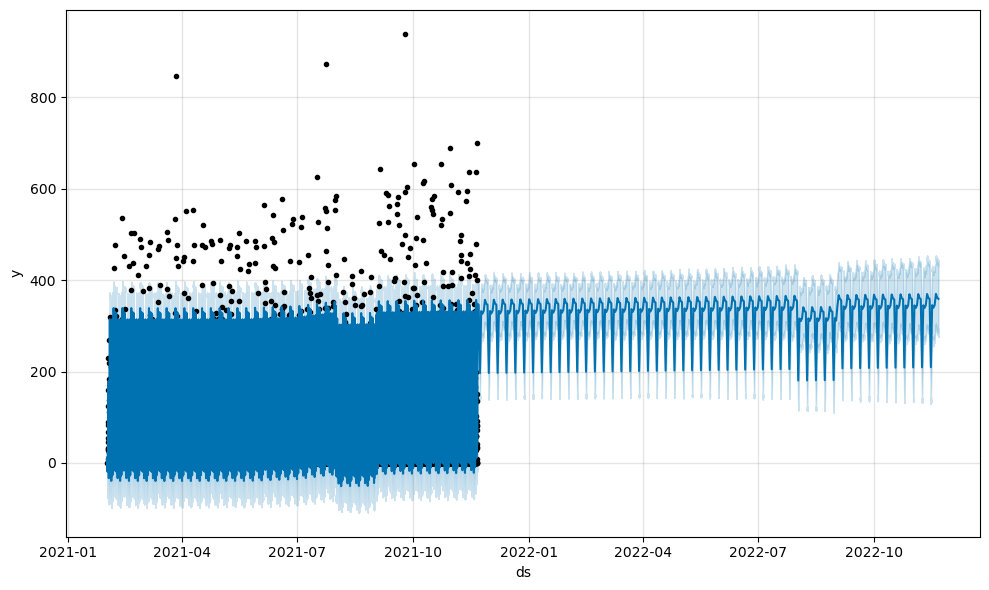

In [129]:
# Ensure 'ds' column is in datetime format
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

# Define and fit the model
model = Prophet()

# Add additional regressors
# model.add_regressor('hourly_outlier_flag')
model.add_regressor('weekly_seasonality')
model.add_regressor('is_august')

model.fit(prophet_df)

# Predict on the test set
# Make future dataframe
future = model.make_future_dataframe(periods=365)

# Add 'hourly_outlier_flag', 'weekly_seasonality' and 'is_august' to future
future['hour'] = future['ds'].dt.hour
future['dayofweek'] = future['ds'].dt.dayofweek

# Use the hour and day of week to match the 'hourly_outlier_flag' and 'weekly_seasonality' from the past data
data['hour'] = data['time'].dt.hour
data['dayofweek'] = data['time'].dt.dayofweek

future = future.merge(data[['hour', 'dayofweek', 'hourly_outlier_flag', 'weekly_seasonality']], on=['hour', 'dayofweek'], how='left')

# Add 'is_august'
future['is_august'] = future['ds'].dt.month == 8

# Now you can predict
forecast = model.predict(future)


# Visualize the forecast
model.plot(forecast)
plt.show()


In [128]:
data

,time,orders,city,hourly_outlier_flag,weekly_seasonality,is_august
time,,,,,,
2021-02-01 00:00:00,2021-02-01 00:00:00,0.0,BCN,0,0,0
2021-02-01 01:00:00,2021-02-01 01:00:00,0.0,BCN,0,0,0
2021-02-01 02:00:00,2021-02-01 02:00:00,0.0,BCN,0,0,0
2021-02-01 03:00:00,2021-02-01 03:00:00,0.0,BCN,0,0,0
2021-02-01 04:00:00,2021-02-01 04:00:00,0.0,BCN,0,0,0
...,...,...,...,...,...,...
2022-02-01 19:00:00,2022-02-01 19:00:00,101.0,BCN,0,0,0
2022-02-01 20:00:00,2022-02-01 20:00:00,266.0,BCN,0,0,0
2022-02-01 21:00:00,2022-02-01 21:00:00,298.0,BCN,0,1,0


## Appendix

In [26]:
daily['index'] = pd.to_datetime(daily['index'])  # ensure 'index' is of datetime type
olymp_start_date = pd.to_datetime('2021-07-23')
olymp_end_date = pd.to_datetime('2021-08-08')
daily['color_group'] = np.where((daily['index'] >= olymp_start_date) & (daily['index'] <= olymp_end_date), 'Olympics', 'Other dates')

import plotly.graph_objects as go

# Create a line for the entire date range
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=daily['index'],
        y=daily['orders'],
        line=dict(color='blue'),
        name='Other dates'
    )
)

# Overlay a line for the Olympics date range
olympics_data = daily[(daily['index'] >= olymp_start_date) & (daily['index'] <= olymp_end_date)]
fig.add_trace(
    go.Scatter(
        x=olympics_data['index'],
        y=olympics_data['orders'],
        line=dict(color='red'),
        name='Olympics',
    )
)
fig.update_layout(title='Agg Orders Before/After Olympics')
fig.show()


It seems that during the Olympics daily trends were much more volatile. Let's look at the rolling variance for 16 day periods (the Olympics were for 16 days) to confirm.

In [26]:
# Create a new column 'orders_log' to store the log of orders
daily['orders_log'] = np.log(daily['orders'] + 0.001)

# Calculate rolling variance for every 16 day window
daily['rolling_variance'] = daily['orders_log'].rolling(window=16).var()

# Plot the rolling variances using Plotly Express
fig = px.line(daily, x='time', y='rolling_variance')

# Add vertical lines for the Olympics start and end dates
fig.add_vline(x=olymp_start_date, line_dash='dash', line_color='red', name='Start of Olympics')
fig.add_vline(x=olymp_end_date, line_dash='dash', line_color='green', name='End of Olympics')

fig.update_layout(
    title='Rolling Variance of Orders (16-day windows)',
    xaxis_title='Time',
    yaxis_title='Variance',
    yaxis_range=[0, 0.25]  # Set the range of the y-axis from 0 to 0.25
)

fig.show()


We can see the volatility is significantly higher during the Olympics compared to other 16 day periods, then reduces afterwards. 

July 23 was the opening ceremony of the Tokyo Olympics, so we have an outlier there of much higher orders. I've highlighted the Olypics in red. As you can see, there's a much more erratic pattern Then the lower order trend continues for all of August, which according to my Catalan friends is when people take off work and go traveling. 

From this EDA, we'll derive the following takeaways:
- Low sales in August is a seasonal trend for Barcelona
- There are a few days in July that are outliers and not representative of the usual situation.


## Modelling

Try different models. Validate each model in a way that would imitate the real problem (every sunday you forecast all of next week). Watch out for data leakage. Evaluate each model on MSE and SMAPE. Which one performs better?